# Home Credit Risk Prediction

## Project Background
Recently, Home Credit endeavours to expand financial inclusion for the unbanked by providing a positive and secure lending experience, whereas some people do not understand or find the system difficult to apply for loans.

Home Credit uses various historical data to predict the repayment ability of customers. Therefore, some people who experience difficulties can be assured of a positive and comfortable lending experience,

By doing so, Home Credit will provide the best solutions for customers so that they do not experience problems during the loan process, both in terms of nominal price, payment date, and maturity date.


### OBJECTIVES
To use Exploratory Data Analysis to understand the data and identify the hidden trends, anomalies, patterns, or relationships within the data.

To starts out with a high-level overview, then narrows into specific areas as we find intriguing areas of the data and find the important features in the dataset.

### Load the data

In [1]:
import pandas as pd 
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline 


from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

from matplotlib.colors import Normalize, TwoSlopeNorm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df_train = pd.read_csv('application_train.csv')

In [3]:
print('Total of columns and rows :', df_train.shape)
df_train.head()

Total of columns and rows : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


There are a total of **307,511 lines containing loan information and there are 122 regarding the identity of the customer and the loan features used.**

The **TARGET feature defines if a customer is experiencing payment difficulties** which means he/she is more than X days late on at least one of the first Y installments of the loan. Such cases are marked as 1 while all other cases are marked as 0.

# Exploratory Data Analysis (EDA)


Check Data Types
--

In [4]:
print('Data types:')
df_train.info(verbose = True)

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int6

In [5]:
payment_map = {0:'No Payment Difficulties', 1:'Payment Difficulties'}
def decode (lbl):
    return payment_map[int(lbl)]

df_train['Payment Condition'] = df_train['TARGET'].apply(lambda x:decode(x))
noc = df_train.groupby(['TARGET','Payment Condition'])['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Total'}, inplace = True)

noc['Percentage'] = round(noc['Total']/sum(noc['Total']),2)

noc

,TARGET,Payment Condition,Total,Percentage
0,0,No Payment Difficulties,282686,0.92
1,1,Payment Difficulties,24825,0.08


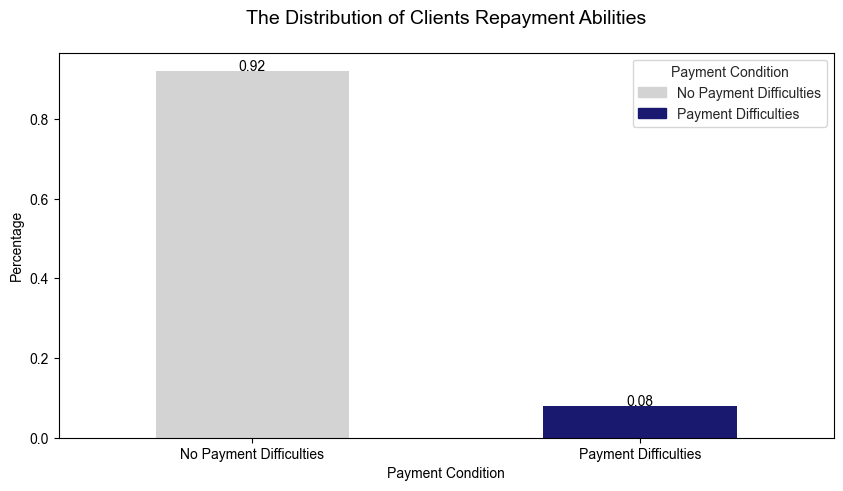

In [6]:
fig,ax = plt.subplots(figsize = (10,5))
bar_plot = noc.plot(kind='bar', color= ['lightgrey','midnightblue'], rot = 0, ax=ax, x='Payment Condition', y='Percentage')
sns.set_style('whitegrid')
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage')

legend_categories = noc['Payment Condition'].unique()
handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['lightgrey', 'midnightblue'][:len(legend_categories)]]
labels = legend_categories

# Set legend with custom handles and labels
plt.legend(handles, labels, title='Payment Condition', loc='upper right')

for p in bar_plot.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:.2f}'.format(height),
            ha="center", va="baseline", fontsize=10, color='black')

plt.savefig('The Distribution of Clients Repayment Abilities.jpg')    
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Help on Legend in module matplotlib.legend object:

class Legend(matplotlib.artist.Artist)
 |  Legend(parent, handles, labels, *, loc=None, numpoints=None, markerscale=None, markerfirst=True, reverse=False, scatterpoints=None, scatteryoffsets=None, prop=None, fontsize=None, labelcolor=None, borderpad=None, labelspacing=None, handlelength=None, handleheight=None, handletextpad=None, borderaxespad=None, columnspacing=None, ncols=1, mode=None, fancybox=None, shadow=None, title=None, title_fontsize=None, framealpha=None, edgecolor=None, facecolor=None, bbox_to_anchor=None, bbox_transform=None, frameon=None, handler_map=None, title_fontproperties=None, alignment='center', ncol=1, draggable=False)
 |  
 |  Place a legend on the figure/axes.
 |  
 |  Method resolution order:
 |      Legend
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, parent, handles, labels, *, loc=None, numpoints=None, markerscale=None, markerfirst=True, reve

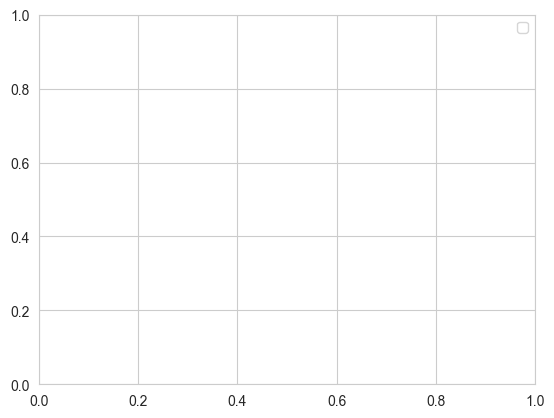

In [7]:
help(plt.legend())

0 = There are around **92%  or around 282k customers** who do not experience problems in repaying loans with <mark>'TARGET = 0</mark>.<br> 
1 = In addition, there are **8% or around 24k customers** who experience problems in repaying loans with <mark> TARGET = 1</mark>.

**Note** : This dataset is imbalanced and it does require special treatment or resampling. The resampling step will be carried out in the model building section

Bivariate Analyze : Categorical vs Target
---

### Contract Type vs Target


In [8]:
contract = df_train.groupby(['NAME_CONTRACT_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
contract.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)

contract


name_con = list(contract['NAME_CONTRACT_TYPE'].unique())
percentage = []

for i in name_con:
    data = contract[contract['NAME_CONTRACT_TYPE'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        
        
contract['percentage'] = percentage
contract       

,NAME_CONTRACT_TYPE,Payment Condition,Total,percentage
0,Cash loans,No Payment Difficulties,255011,0.92
1,Cash loans,Payment Difficulties,23221,0.08
2,Revolving loans,No Payment Difficulties,27675,0.95
3,Revolving loans,Payment Difficulties,1604,0.05


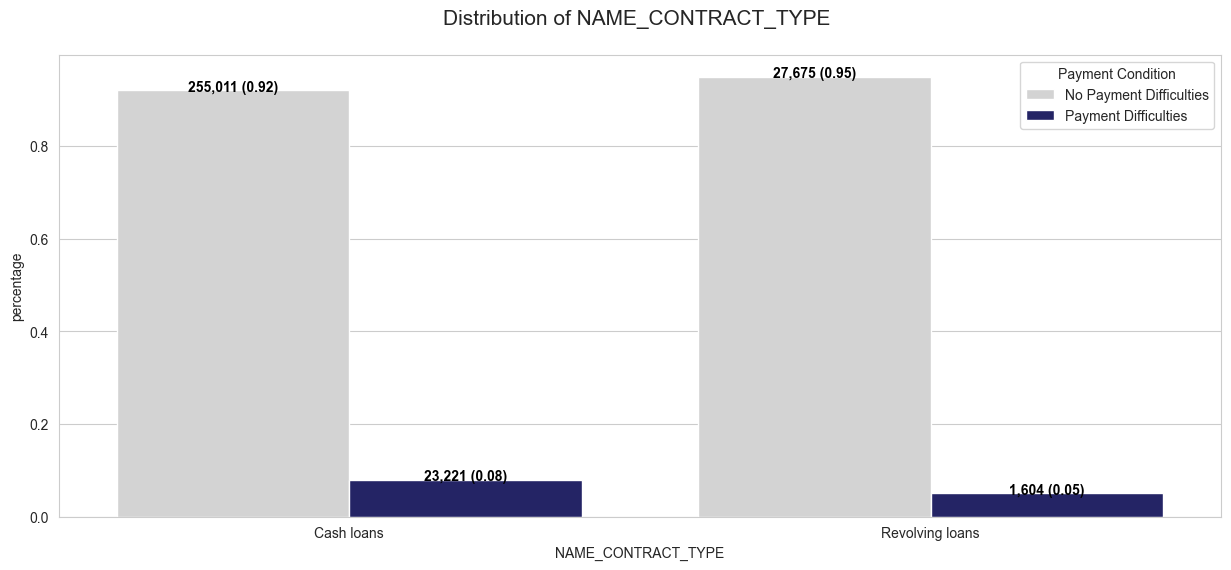

In [9]:
contract = contract.sort_values(by='Total', ascending = False)

def bar_plot(data,x,y=None,hue=None,Total=None, savefig = None):
    fig, ax = plt.subplots(figsize = (15,6))
    custom_palette = ['lightgrey','midnightblue']
    sns.set_style('whitegrid')
    sns.set_palette(custom_palette)
    ax = sns.barplot(data=data, x=x, y=y, hue=hue)
    plt.title('Distribution of {} \n'.format(str(x)), fontsize = 15)
    for p, percentage,Total in zip(ax.patches,data[y],data[Total]):
            height = p.get_height() if y is None else p.get_height() - 0.001
            ax.text(p.get_x() + p.get_width() / 2., height,
                    '{:,.0f} ({})'.format(Total, percentage),
                    ha="center", va="baseline", fontsize=10, color='black',fontweight = 'bold')
    plt.savefig('{}.jpg'.format(savefig))
    plt.show()
 

    
bar_plot(contract, x='NAME_CONTRACT_TYPE',y='percentage', hue='Payment Condition',Total='Total',savefig = 'Distribution')

1. **Cash loans**: Customers who repay loans in cash experience more problems in repaying loans, namely **8% or around 23k of 278k customers.**

2. **Revolving loans**: Customers who repay loans on a revolving basis experience problems as much as **5% or around 1k of 27k customers.**

In [10]:
df_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

### Code Gender vs Target

In [11]:
df_train['CODE_GENDER'] = df_train['CODE_GENDER'].replace(['XNA'], df_train['CODE_GENDER'].mode()[0])
code_gender = df_train.groupby(['CODE_GENDER','Payment Condition'])['SK_ID_CURR'].count().reset_index()
code_gender.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)
code_gender['CODE_GENDER'] = code_gender['CODE_GENDER'].replace(['F','M'],['Female','Male'])

code = list(code_gender['CODE_GENDER'].unique())
percentage = []



for i in code:
    data = code_gender[code_gender['CODE_GENDER'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
code_gender['percentage'] = percentage
code_gender

,CODE_GENDER,Payment Condition,Total,percentage
0,Female,No Payment Difficulties,188282,0.93
1,Female,Payment Difficulties,14170,0.07
2,Male,No Payment Difficulties,94404,0.90
3,Male,Payment Difficulties,10655,0.10


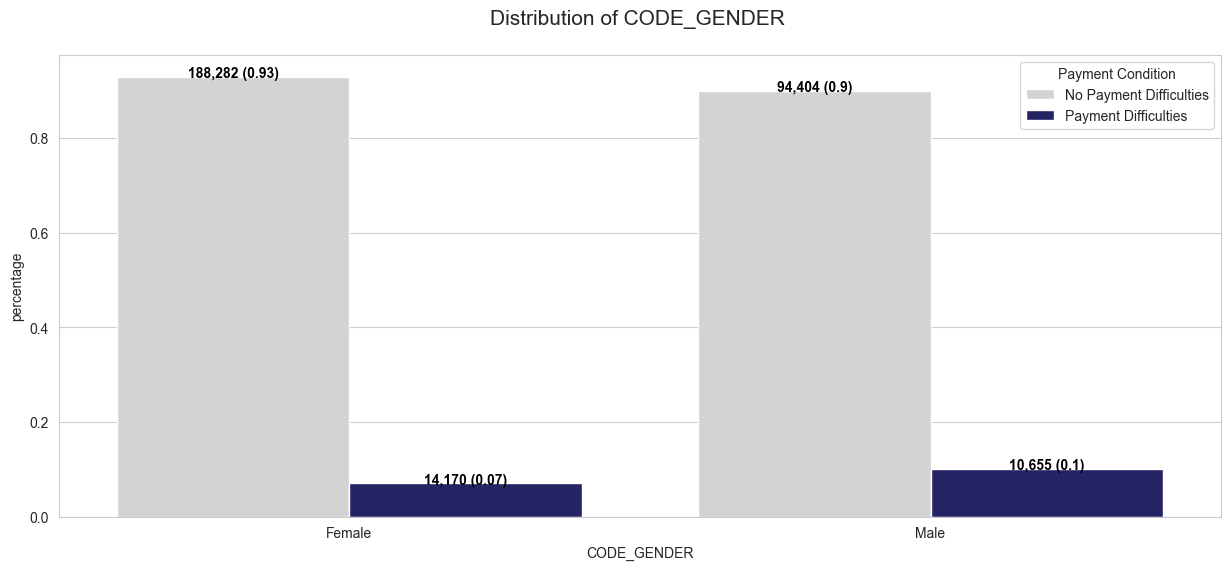

In [12]:
df_train['CODE_GENDER'] = df_train['CODE_GENDER'].replace(['F','M'],['Female','Male'])
code_gender = code_gender.loc[(code_gender['CODE_GENDER'] == 'Female') | (code_gender['CODE_GENDER'] == 'Male')]
code_gender = code_gender.sort_values(by='Total', ascending = False)

bar_plot(code_gender, x='CODE_GENDER',y='percentage', hue='Payment Condition',Total='Total',savefig = 'CODE_GENDER')

1. **Female**: Some female customers had problems repaying their loans by **7% or around 14k of the total Female Customers**

2.  **Male**: Some male customers experienced problems with loan repayment as much as **10% or around 10k of the total Male Customers**

It can be concluded that from the whole customers, <mark> Male Customers</mark> experience more problems than <mark> Female Customers</mark>.

### Car Ownership Status Vs Target

In [13]:
own_car = df_train.groupby(['FLAG_OWN_CAR','Payment Condition'])['SK_ID_CURR'].count().reset_index()
own_car['FLAG_OWN_CAR'] = own_car['FLAG_OWN_CAR'].replace(['Y', 'N'], ['Yes','No'])
own_car.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)
own = list(own_car['FLAG_OWN_CAR'].unique())
percentage = []



for i in own:
    data = own_car[own_car['FLAG_OWN_CAR'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
own_car['percentage'] = percentage
own_car = own_car.sort_values(by=['Total'], ascending = False)
own_car = own_car.reindex(index=[2,0,3,1])
own_car.reset_index().drop('index',axis =1)

,FLAG_OWN_CAR,Payment Condition,Total,percentage
0,Yes,No Payment Difficulties,97011,0.93
1,No,No Payment Difficulties,185675,0.91
2,Yes,Payment Difficulties,7576,0.07
3,No,Payment Difficulties,17249,0.09


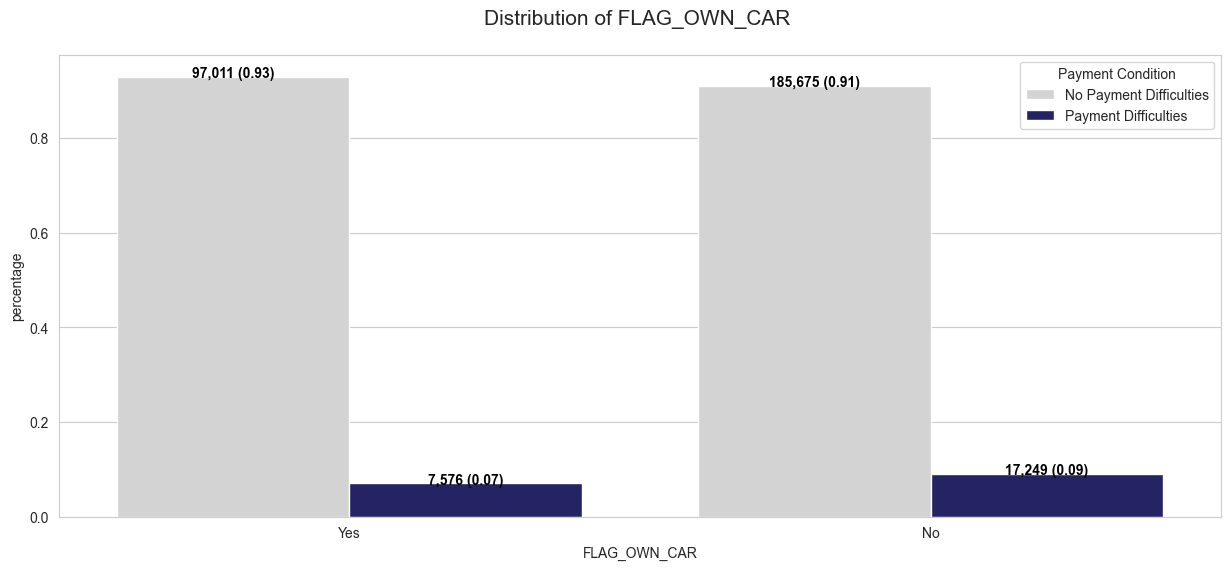

In [14]:
bar_plot(own_car, x='FLAG_OWN_CAR',y='percentage', hue='Payment Condition',Total='Total', savefig = 'FLAG_OWN_CAR')

1. **Customers who own cars**:  Some customers who own cars are having problems with credit payments as much as **7% or around 7k of the total customers who own cars.**

2. **Customers who do not own a car**: Some customers who do not own a car have problems with loan repayments as much as **9% or around 17k of the total customers who do not own a car.**

It can be concluded that of all customers, <mark>Customers who do not own a car</mark> have more problems than <mark>Customers who own a car</mark>.

### Realty Ownership Status Vs Target

In [15]:
df_train['FLAG_OWN_REALTY']

0         Y
1         N
2         Y
3         Y
4         Y
         ..
307506    N
307507    Y
307508    Y
307509    Y
307510    N
Name: FLAG_OWN_REALTY, Length: 307511, dtype: object

In [16]:
own_realty = df_train.groupby(['FLAG_OWN_REALTY','Payment Condition'])['SK_ID_CURR'].count().reset_index()
own_realty.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)
own_realty['FLAG_OWN_REALTY'] = own_realty['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])


own_re = list(own_realty['FLAG_OWN_REALTY'].unique())
percentage = []



for i in own_re:
    data = own_realty[own_realty['FLAG_OWN_REALTY'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
own_realty['percentage'] = percentage
own_realty = own_realty.sort_values(by='Total', ascending = False)
own_realty = own_realty.reset_index().drop('index', axis = 1)
own_realty

,FLAG_OWN_REALTY,Payment Condition,Total,percentage
0,Yes,No Payment Difficulties,196329,0.92
1,No,No Payment Difficulties,86357,0.92
2,Yes,Payment Difficulties,16983,0.08
3,No,Payment Difficulties,7842,0.08


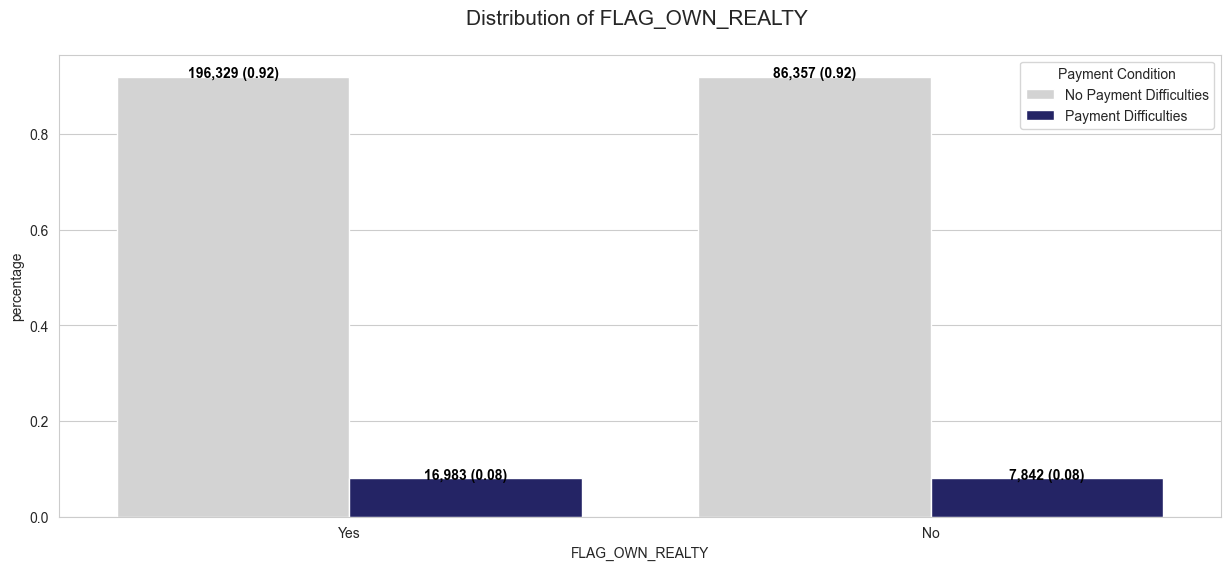

In [17]:
bar_plot(own_realty, x='FLAG_OWN_REALTY',y='percentage', hue='Payment Condition',Total='Total')

There is nothing special in <mark>FLAG_OWN_REALTY</mark> about whether a customer owns a house/flat or not, **as the issue of loans received between the two categories is not very significant.**

### Marital Status vs Target

In [18]:
df_train['NAME_FAMILY_STATUS'].unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [19]:
married = ['Married', 'Civil marriage']
mrd_stats = []
for i in df_train['NAME_FAMILY_STATUS']:
    if i in married:
        mrd_stats.append('Married')
    else:
        mrd_stats.append('Unmarried')
        
df_train['married_stats'] = mrd_stats
df_train['married_stats']

0         Unmarried
1           Married
2         Unmarried
3           Married
4         Unmarried
            ...    
307506    Unmarried
307507    Unmarried
307508    Unmarried
307509      Married
307510      Married
Name: married_stats, Length: 307511, dtype: object

In [20]:
married = df_train.groupby(['married_stats','Payment Condition'])['SK_ID_CURR'].count().reset_index()
married.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


marr_stats = list(married['married_stats'].unique())
percentage = []



for i in marr_stats:
    data = married[married['married_stats'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
married['percentage'] = percentage
married = married.sort_values(by='Total', ascending = False)
married = married.reset_index().drop('index', axis = 1)
married

,married_stats,Payment Condition,Total,percentage
0,Married,No Payment Difficulties,208396,0.92
1,Unmarried,No Payment Difficulties,74290,0.91
2,Married,Payment Difficulties,17811,0.08
3,Unmarried,Payment Difficulties,7014,0.09


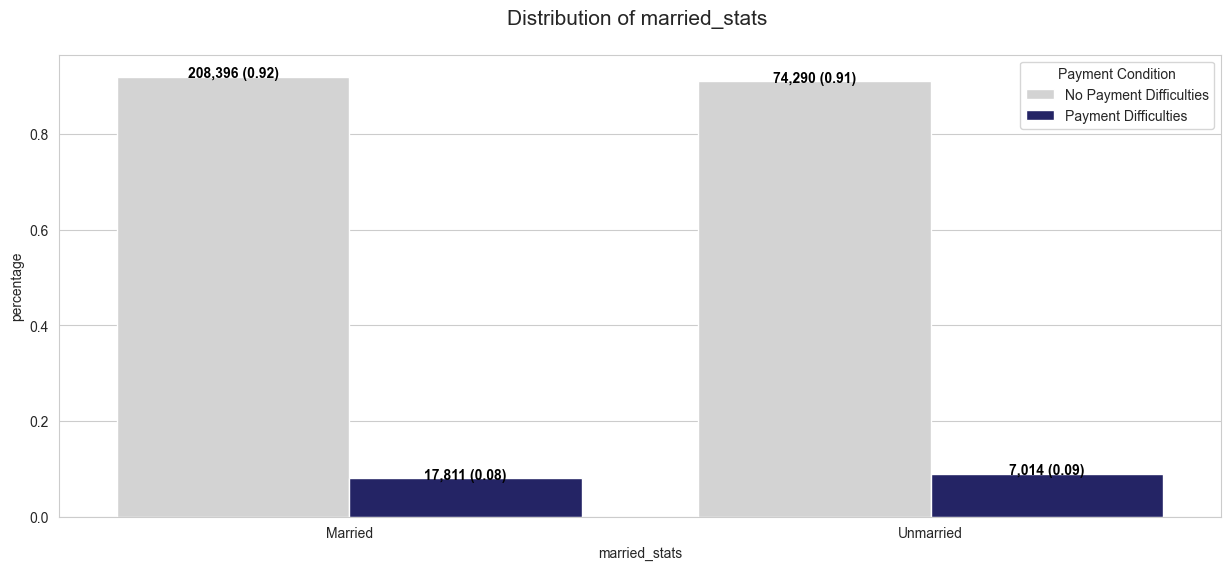

In [21]:
bar_plot(married, x='married_stats',y='percentage', hue='Payment Condition',Total='Total',savefig = 'married_stats')

1. **Married customers**:  Some married customers experienced loan repayment problems as much as **8% or around 17k of the total married customers.**

2. **Non-married customers**: Some customers who are not married or not in a marital status experience loan repayment problems as much as **9% or around 7k of the total customers who are not married or not in a marital status.**

It can be concluded that of all customers, <mark>Unmarried customers</mark> experience more problems than <mark>Married customers</mark>.

### Have a Children vs Target

In [22]:
child = []
for i in df_train['CNT_CHILDREN']:
    if i > 0:
        child.append('have children')
    else:
        child.append('not have children')
        
df_train['children'] = child
df_train['children']

0         not have children
1         not have children
2         not have children
3         not have children
4         not have children
                ...        
307506    not have children
307507    not have children
307508    not have children
307509    not have children
307510    not have children
Name: children, Length: 307511, dtype: object

In [23]:
childs = df_train.groupby(['children','Payment Condition'])['SK_ID_CURR'].count().reset_index()
childs.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


have_childs = list(childs['children'].unique())
percentage = []



for i in have_childs:
    data = childs[childs['children'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
childs['percentage'] = percentage
childs = childs.sort_values(by = 'Total', ascending = False)
childs = childs.reindex([0,2,1,3]).reset_index()
childs = childs.drop('index', axis =1)

childs

,children,Payment Condition,Total,percentage
0,have children,No Payment Difficulties,83924,0.91
1,not have children,No Payment Difficulties,198762,0.92
2,have children,Payment Difficulties,8216,0.09
3,not have children,Payment Difficulties,16609,0.08


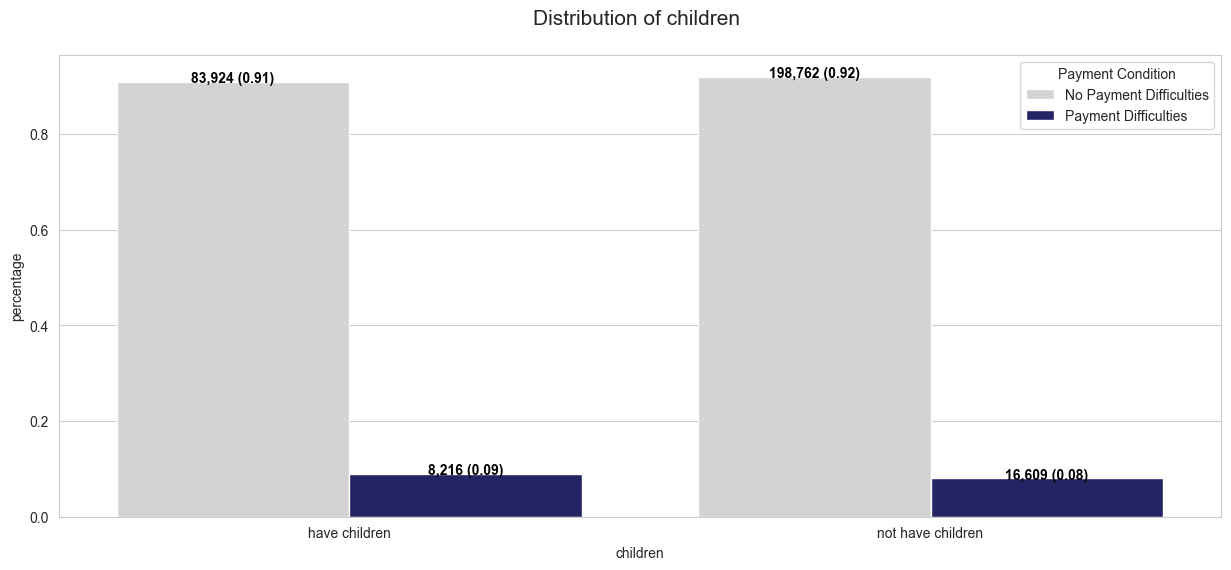

In [24]:
bar_plot(childs, x='children',y='percentage', hue='Payment Condition',Total='Total',savefig='Children')

1. **Customers who have children**:  Some customers who have children experience loan repayment problems as much as **9% or around 8k of the total customers who have children.**

2. **Customers who do not have children**: Some customers who do not have children experience loan repayment problems as much as **8% or around 16k of the total customers who do not have children.**

It can be concluded that of all customers, <mark>Customers who have children</mark> experience more problems than <mark>Customers who do not have children</mark>.

### Age of Customers vs Target

In [25]:
df_train['Age'] = np.floor(df_train['DAYS_BIRTH'] / -365).astype('int64')
df_train.drop(columns= 'DAYS_BIRTH', inplace=True)

Group based on Customers Age following this rules :

1. **Young Adult** = 20 - 39
2. **Middle Adult** = 40 - 59
3. **Older** > 60

In [26]:
age_cat = []
for i in df_train['Age']:
    if i < 40:
        age_cat.append('Young adult')
    elif i < 60:
        age_cat.append('Middle adult')
    else:
        age_cat.append('Older')

df_train['Age Category'] = age_cat
df_train['Age Category']

0          Young adult
1         Middle adult
2         Middle adult
3         Middle adult
4         Middle adult
              ...     
307506     Young adult
307507    Middle adult
307508    Middle adult
307509     Young adult
307510    Middle adult
Name: Age Category, Length: 307511, dtype: object

In [27]:
age_prob = df_train.groupby(['Age Category','Payment Condition'])['SK_ID_CURR'].count().reset_index()
age_prob.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


age_unik = list(age_prob['Age Category'].unique())
percentage = []



for i in age_unik:
    data = age_prob[age_prob['Age Category'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
age_prob['Percentage'] = percentage
age_prob = age_prob.sort_values(by='Total', ascending = False)
age_prob = age_prob.reindex([4,0,2,5,1,3]).reset_index()
age_prob = age_prob.drop('index', axis =1)

age_prob

,Age Category,Payment Condition,Total,Percentage
0,Young adult,No Payment Difficulties,114259,0.90
1,Middle adult,No Payment Difficulties,134584,0.93
2,Older,No Payment Difficulties,33843,0.95
3,Young adult,Payment Difficulties,13040,0.10
4,Middle adult,Payment Difficulties,10033,0.07
5,Older,Payment Difficulties,1752,0.05


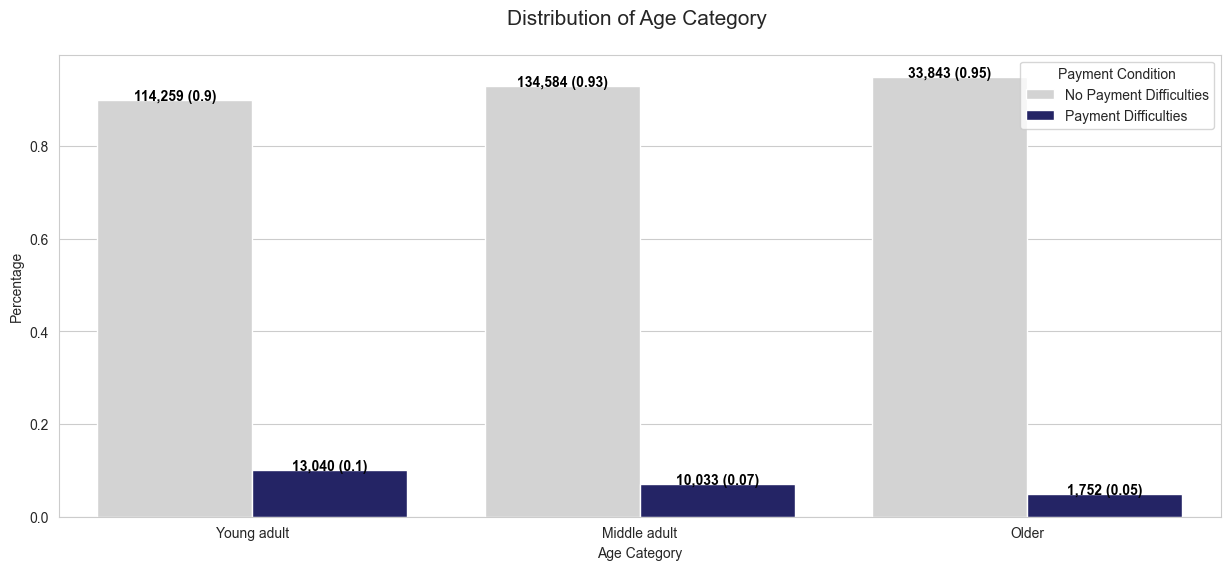

In [28]:
bar_plot(age_prob, x='Age Category',y='Percentage', hue='Payment Condition',Total='Total', savefig = 'Age_Category')

It turns out that those who experience the most problems are customers **Aged 20 - 59** (**Young Adult** & **Middle Adult**)

### Housing Type vs Target

In [29]:
df_train['NAME_HOUSING_TYPE']
df_train['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

In [30]:
house_type= df_train.groupby(['NAME_HOUSING_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
house_type.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


house = list(house_type['NAME_HOUSING_TYPE'].unique())
percentage = []



for i in house:
    data = house_type[house_type['NAME_HOUSING_TYPE'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
house_type['percentage'] = percentage
house_type = house_type.sort_values(by='Total', ascending = False)
house_type.reset_index().drop('index',axis = 1)

,NAME_HOUSING_TYPE,Payment Condition,Total,percentage
0,House / apartment,No Payment Difficulties,251596,0.92
1,House / apartment,Payment Difficulties,21272,0.08
2,With parents,No Payment Difficulties,13104,0.88
3,Municipal apartment,No Payment Difficulties,10228,0.91
4,Rented apartment,No Payment Difficulties,4280,0.88
5,Office apartment,No Payment Difficulties,2445,0.93
6,With parents,Payment Difficulties,1736,0.12
7,Co-op apartment,No Payment Difficulties,1033,0.92
8,Municipal apartment,Payment Difficulties,955,0.09
9,Rented apartment,Payment Difficulties,601,0.12


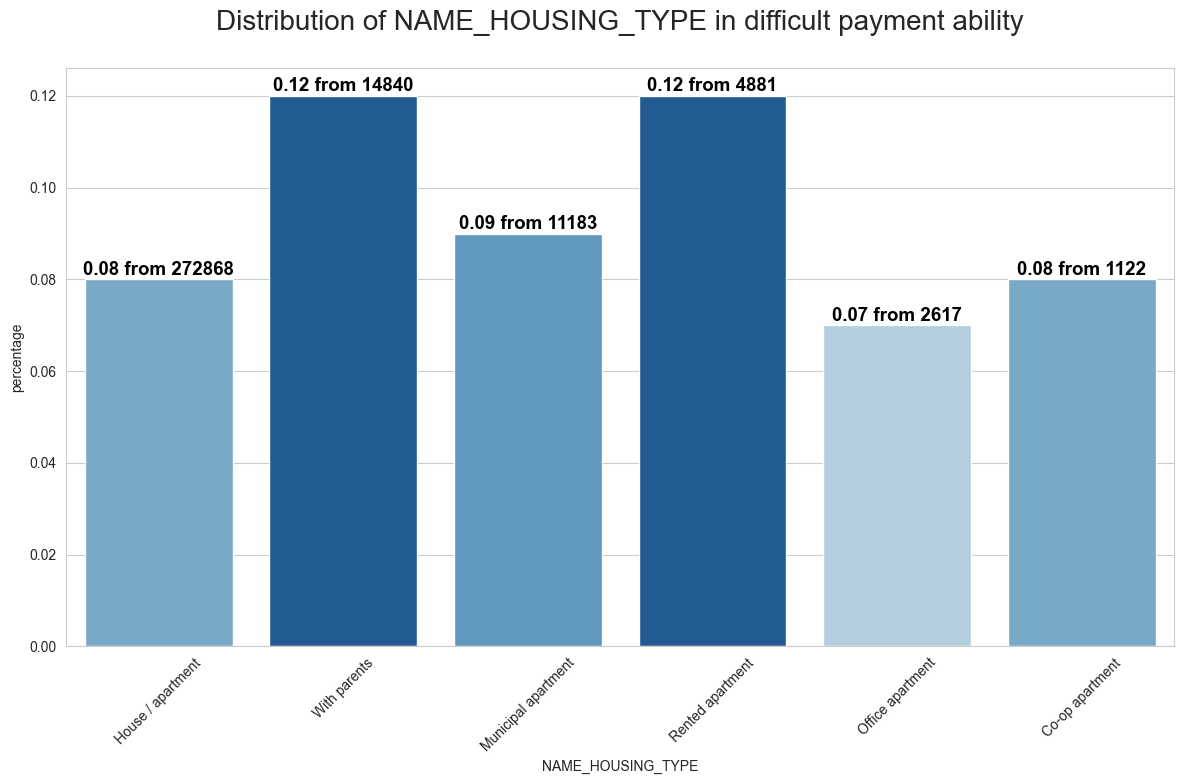

,NAME_HOUSING_TYPE,Payment Condition,Total,percentage,count
0,House / apartment,Payment Difficulties,21272,0.08,272868
1,With parents,Payment Difficulties,1736,0.12,14840
2,Municipal apartment,Payment Difficulties,955,0.09,11183
3,Rented apartment,Payment Difficulties,601,0.12,4881
4,Office apartment,Payment Difficulties,172,0.07,2617
5,Co-op apartment,Payment Difficulties,89,0.08,1122


In [31]:
house_type = house_type[house_type['Payment Condition']== 'Payment Difficulties' ]
house_type = house_type.sort_values(by='Total',ascending=False)

def bar_plot_many(data,x,y,Total=None,savefig = None):
    fig,ax = plt.subplots(figsize=(12,8))
    sns.set(style='whitegrid',color_codes = True)
    
    norm = TwoSlopeNorm(vmin=data[y].min()-0.02, vcenter=round(data[y].median(),2), vmax=data[y].max()+0.02)
    colors = [plt.cm.Blues(norm(c)) for c in data[y]]
    ax = sns.barplot(data=data, x=x, y=y,palette = colors)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    plt.legend('',frameon=False)
    plt.title('Distribution of {} in difficult payment ability\n'.format(str(x)), fontsize = 20)
    for p, percentage_value, total_value in zip(ax.patches,data[y],Total):
            height = p.get_height() if y is None else p.get_height() + 0.001
            ax.text(p.get_x() + p.get_width() / 2., height,
                    '{:} from {}'.format(percentage_value,total_value),
                    ha="center", va="baseline", fontsize=13.5, color='black',fontweight = 'bold')
    plt.tight_layout()
    plt.savefig('{}.jpg'.format(savefig))
    plt.show()
    
    

 
    

bar_plot_many(house_type, x='NAME_HOUSING_TYPE',y='percentage', Total = df_train['NAME_HOUSING_TYPE'].value_counts(),savefig = 'HOUSING_TYPE')
house_merge = pd.merge(house_type,df_train['NAME_HOUSING_TYPE'].value_counts(),how='outer',on=['NAME_HOUSING_TYPE'])
house_merge

There are 2 <mark>Housing types</mark> that have the least number of customers compared to other types, namely **Office Apartments and Co-operative Apartments with about 7 - 8%. or about 261 customers from both types who have loan repayment problems.**

Therefore, we will identify the types of loan repayments that have been made by some customers in this category.

In [32]:
prob_house = df_train.groupby(['NAME_HOUSING_TYPE','NAME_CONTRACT_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
prob_house.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


prob_house = prob_house.sort_values(by='Total', ascending = False)
prob_house = prob_house[prob_house['NAME_HOUSING_TYPE'].isin(['Office apartment','Co-op apartment']) & (prob_house['Payment Condition'] == 'Payment Difficulties')]
prob_house.reset_index().drop('index',axis='columns')

,NAME_HOUSING_TYPE,NAME_CONTRACT_TYPE,Payment Condition,Total
0,Office apartment,Cash loans,Payment Difficulties,159
1,Co-op apartment,Cash loans,Payment Difficulties,83
2,Office apartment,Revolving loans,Payment Difficulties,13
3,Co-op apartment,Revolving loans,Payment Difficulties,6


It turns out that of the two types of loan repayment, the type of repayment in **Cash Loans has the most problems.**

So that this can be used as material for conducting campaigns so that some people who experience problems in applying for loans can be resolved.

### Incoming Type vs Target

In [33]:
income_type = df_train.groupby(['NAME_INCOME_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
income_type.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


inc = list(income_type['NAME_INCOME_TYPE'].unique())
percentage = []



for i in inc:
    data = income_type[income_type['NAME_INCOME_TYPE'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
income_type['percentage'] = percentage
income_type = income_type[income_type['Payment Condition']== 'Payment Difficulties' ]
income_type = income_type.sort_values(by='Total', ascending = False)

income_type = income_type.reset_index().drop('index', axis = 1)
income_type

,NAME_INCOME_TYPE,Payment Condition,Total,percentage
0,Working,Payment Difficulties,15224,0.10
1,Commercial associate,Payment Difficulties,5360,0.07
2,Pensioner,Payment Difficulties,2982,0.05
3,State servant,Payment Difficulties,1249,0.06
4,Unemployed,Payment Difficulties,8,0.36
5,Maternity leave,Payment Difficulties,2,0.40


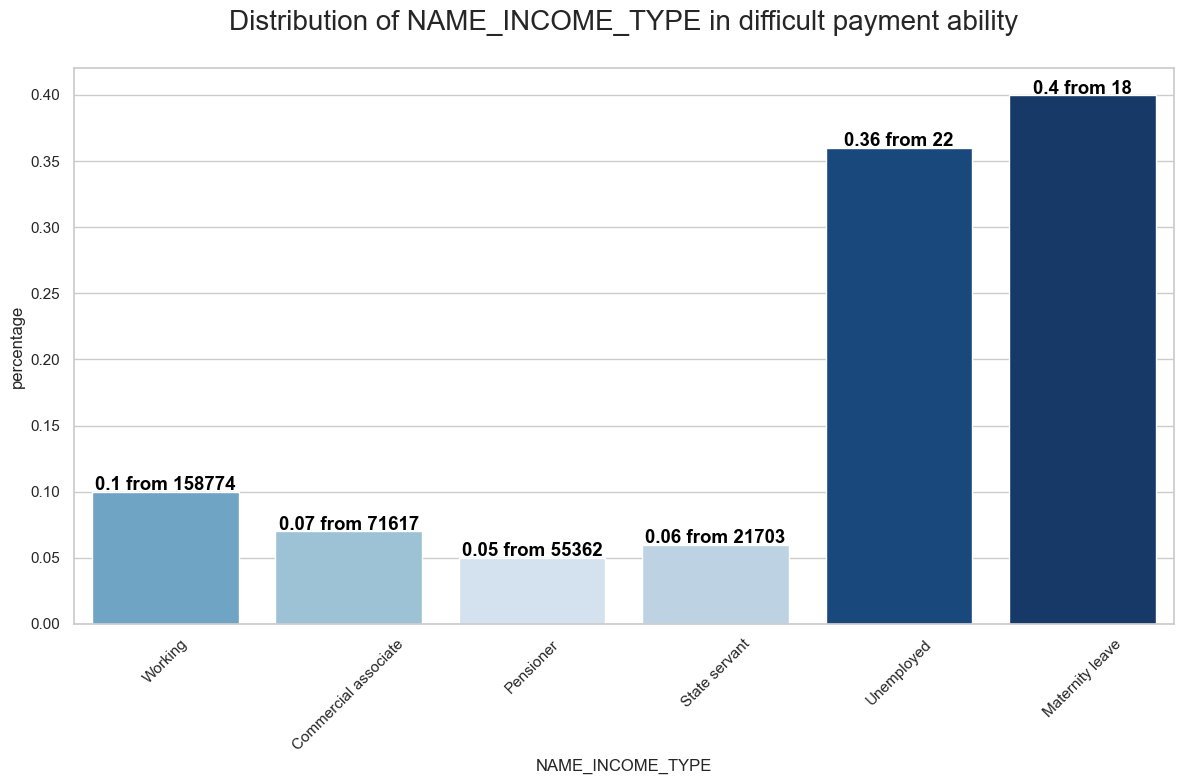

,NAME_INCOME_TYPE,Payment Condition,Total,percentage,count
0,Working,Payment Difficulties,15224.0,0.10,158774
1,Commercial associate,Payment Difficulties,5360.0,0.07,71617
2,Pensioner,Payment Difficulties,2982.0,0.05,55362
3,State servant,Payment Difficulties,1249.0,0.06,21703
4,Unemployed,Payment Difficulties,8.0,0.36,22
5,Maternity leave,Payment Difficulties,2.0,0.40,5
6,Student,NaN,NaN,NaN,18
7,Businessman,NaN,NaN,NaN,10


In [34]:
bar_plot_many(income_type, x='NAME_INCOME_TYPE',y='percentage', Total = df_train['NAME_INCOME_TYPE'].value_counts(), savefig = 'INCOME_TYPE')


income_merge = pd.merge(income_type,df_train['NAME_INCOME_TYPE'].value_counts(),how='outer',on=['NAME_INCOME_TYPE'])
income_merge

There are 2 <mark>Types of Income</mark> that have the least number of customers compared to other types, namely **Not Working and Maternity Leave with 36 - 40% or around 27 customers who have experienced loan repayment problems.**

It turns out that the total number of customers experiencing problems is almost half of all customers of the two types, while the total number of customers of the two types does not reach 100 people.

Therefore, we will identify what type of loan repayment has been applied for by some of these customers

In [35]:
problems = df_train.groupby(['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
problems.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


problems = problems.sort_values(by='Total', ascending = False)
problems = problems[problems['NAME_INCOME_TYPE'].isin(['Unemployed','Maternity leave'])]
problems.reset_index().drop('index',axis='columns')
                

,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Payment Condition,Total
0,Unemployed,Cash loans,Payment Difficulties,8
1,Unemployed,Cash loans,No Payment Difficulties,7
2,Unemployed,Revolving loans,No Payment Difficulties,7
3,Maternity leave,Revolving loans,No Payment Difficulties,3
4,Maternity leave,Cash loans,Payment Difficulties,2


It turns out that of the two types of loan repayments, the type of repayment on **Cash loans has the most problems**. 

However, there are some customers with the type of Unemployed type who make repayments by Cash Loans who do not experience problems.

### Occupation Type vs Target 

In [36]:
df_train['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

In [37]:
occu_type = df_train.groupby(['OCCUPATION_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
occu_type.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)


occ = list(occu_type['OCCUPATION_TYPE'].unique())
percentage = []



for i in occ:
    data = occu_type[occu_type['OCCUPATION_TYPE'] == i]
    total = data['Total'].sum()
    for x,y in enumerate(data['Total']):
        percent = round((y/total),2)
        percentage.append(percent)
        

        
occu_type['percentage'] = percentage
occu_type = occu_type[occu_type['Payment Condition']== 'Payment Difficulties' ]
occu_type = occu_type.sort_values(by='Total', ascending = False)

cupation = df_train['OCCUPATION_TYPE'].value_counts()
occu_merge = pd.merge(occu_type,cupation,how = 'outer', on=['OCCUPATION_TYPE'])

occu_merge

,OCCUPATION_TYPE,Payment Condition,Total,percentage,count
0,Laborers,Payment Difficulties,5838,0.11,55186
1,Sales staff,Payment Difficulties,3092,0.10,32102
2,Drivers,Payment Difficulties,2107,0.11,18603
3,Core staff,Payment Difficulties,1738,0.06,27570
4,Managers,Payment Difficulties,1328,0.06,21371
5,Security staff,Payment Difficulties,722,0.11,6721
6,High skill tech staff,Payment Difficulties,701,0.06,11380
7,Cooking staff,Payment Difficulties,621,0.10,5946
8,Medicine staff,Payment Difficulties,572,0.07,8537
9,Accountants,Payment Difficulties,474,0.05,9813


There are very varied types of customer occupations, so we will filter some types on **customers who do not experience loan repayment problems around 92% - 95% with a total of not too many customers**, so that it can be used as a focus if you want to do a campaign. 

There are several types of jobs, namely, **Accountants, Medical Staff, Private Service Staff, Realty Agents, HR Staff, and IT Staff.**

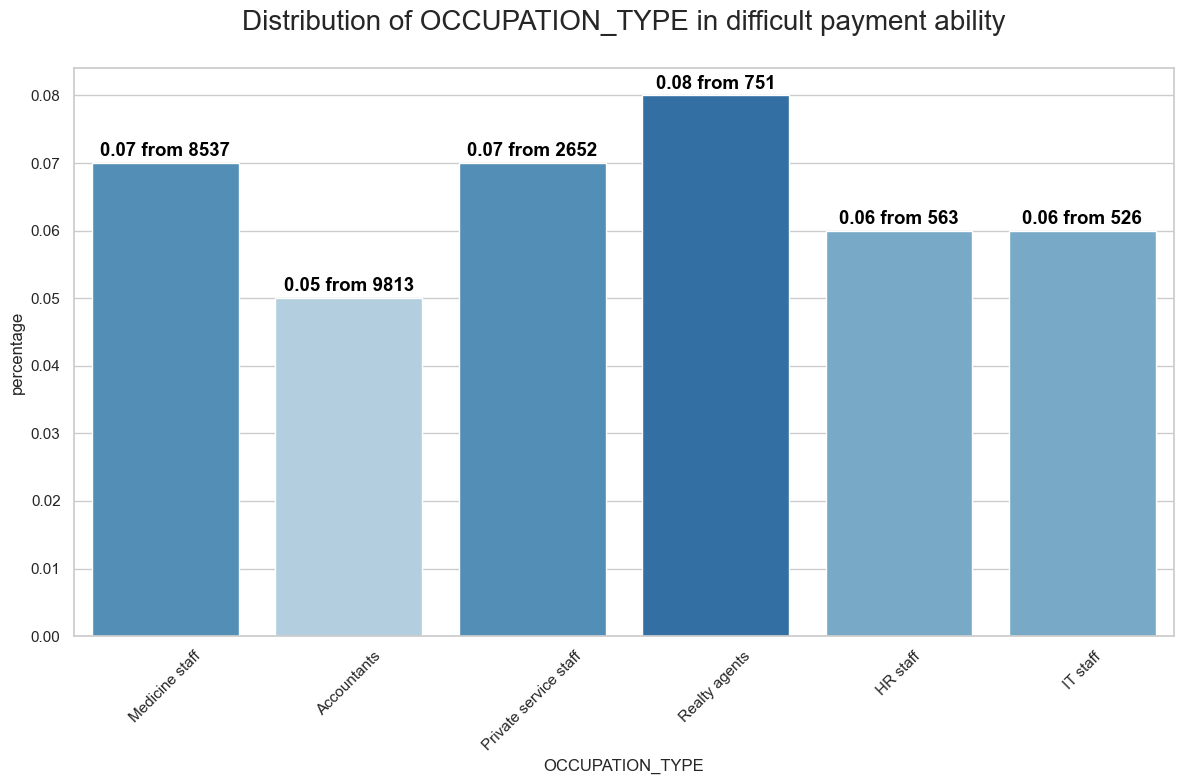

,OCCUPATION_TYPE,Payment Condition,Total,percentage,count
0,Medicine staff,Payment Difficulties,572,0.07,8537
1,Accountants,Payment Difficulties,474,0.05,9813
2,Private service staff,Payment Difficulties,175,0.07,2652
3,Realty agents,Payment Difficulties,59,0.08,751
4,HR staff,Payment Difficulties,36,0.06,563
5,IT staff,Payment Difficulties,34,0.06,526


In [38]:
occu_merge = occu_merge[occu_merge['OCCUPATION_TYPE'].isin(['Accountants','Medicine staff','Private service staff','Realty agents','HR staff','IT staff'])]
bar_plot_many(occu_merge, x='OCCUPATION_TYPE',y='percentage', Total=occu_merge['count'])




occu_merge.reset_index().drop('index',axis=1)

<mark> Let's identify what types of loans have been submitted by some people in that category.</mark>

In [39]:
occu_problems = df_train.groupby(['OCCUPATION_TYPE','NAME_CONTRACT_TYPE','Payment Condition'])['SK_ID_CURR'].count().reset_index()
occu_problems.rename(columns = {'SK_ID_CURR':'Total'}, inplace = True)
occu_problems = occu_problems[occu_problems['OCCUPATION_TYPE'].isin(['Accountants','Medicine staff','Private service staff','Realty agents','HR staff','IT staff']) & (occu_problems['Payment Condition']=='Payment Difficulties')]


occu_problems = occu_problems.sort_values(by='OCCUPATION_TYPE', ascending = True)
occu_problems.reset_index().drop('index',axis='columns')

,OCCUPATION_TYPE,NAME_CONTRACT_TYPE,Payment Condition,Total
0,Accountants,Cash loans,Payment Difficulties,434
1,Accountants,Revolving loans,Payment Difficulties,40
2,HR staff,Cash loans,Payment Difficulties,33
3,HR staff,Revolving loans,Payment Difficulties,3
4,IT staff,Cash loans,Payment Difficulties,33
5,IT staff,Revolving loans,Payment Difficulties,1
6,Medicine staff,Cash loans,Payment Difficulties,530
7,Medicine staff,Revolving loans,Payment Difficulties,42
8,Private service staff,Cash loans,Payment Difficulties,158
9,Private service staff,Revolving loans,Payment Difficulties,17


It turns out that of the two types of loan repayment, the type of repayment in **Cash Loans has the most problems.** So that this can be used as material for conducting campaigns so that some people who experience problems in applying for loans can be resolved.

From several bivariate analysis graphs, it turns out that the repayment of loans by Cash Loans has the most problems, so this raises several questions 

**Do some of them not understand the cash loan repayment system?**

or 

**Are there problems with the cash loan repayment system?**

<mark>Let's dig it deeper</mark>

Bivariate Analyze : Numerical Features vs Target
---

### Amount Credit of the Loan vs Target

In [40]:
df_train['AMT_CREDIT']

0          406597.5
1         1293502.5
2          135000.0
3          312682.5
4          513000.0
            ...    
307506     254700.0
307507     269550.0
307508     677664.0
307509     370107.0
307510     675000.0
Name: AMT_CREDIT, Length: 307511, dtype: float64

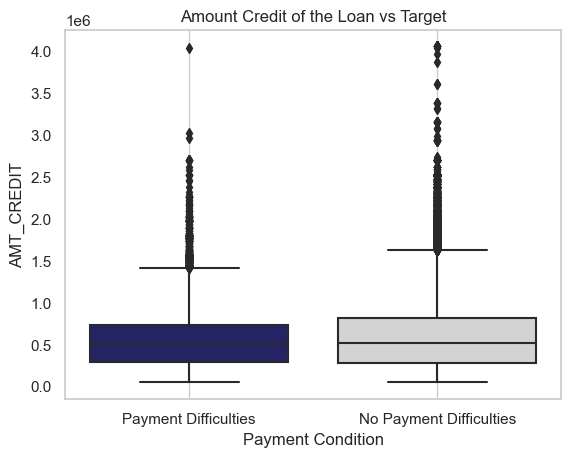

In [41]:
sns.boxplot(x='Payment Condition', y='AMT_CREDIT',data= df_train,palette=['midnightblue','lightgrey'])
plt.grid()
plt.title('Amount Credit of the Loan vs Target')
plt.show()

It can be seen that the median value of the types of loan repayment conditions of **customers who do not experience repayment difficulties is slightly greater than the median value of customers who experience repayment difficulties**. 

This means that **customers with higher loan amounts have a slightly higher chance of repaying their loans than customers with lower loan amounts.**

### Amount Income vs Target

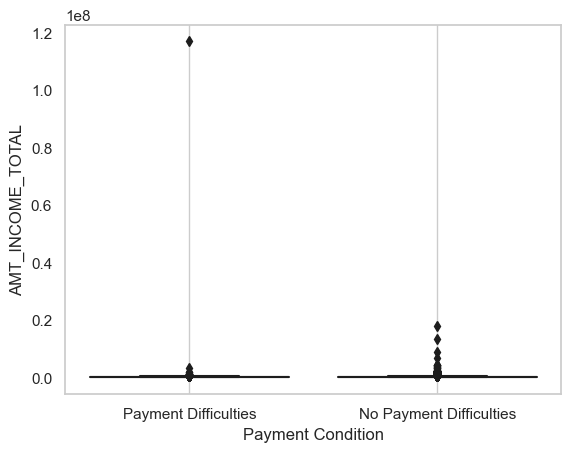

In [42]:
sns.boxplot(x='Payment Condition', y='AMT_INCOME_TOTAL', data=df_train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

It can be seen that customers who experience loan repayment problems and those who do not, **have broadly similar values**. 

It can be concluded, as the **income of customers increases, the probability of customers who do not experience difficulties in paying loans also increases.**

### Amount Goods Price vs Target

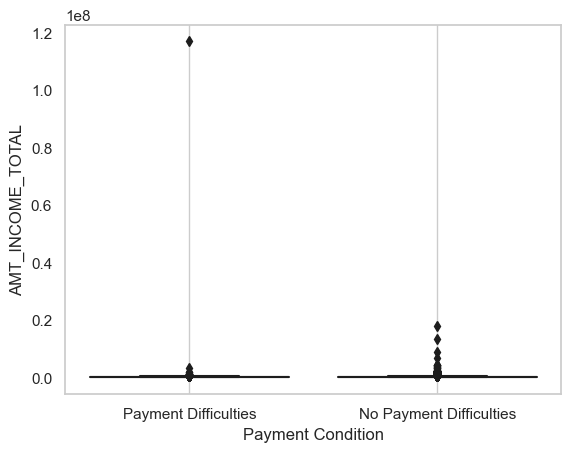

In [43]:
sns.boxplot(x='Payment Condition', y='AMT_INCOME_TOTAL', data=df_train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

It can be seen that customers who experience loan repayment problems and those who do not, **have broadly similar values.**

Multivariate Visualization
---

#### NAME_CONTRACT_TYPE, AMT_INCOME_TOTAL, Payment Condition, & Age Category

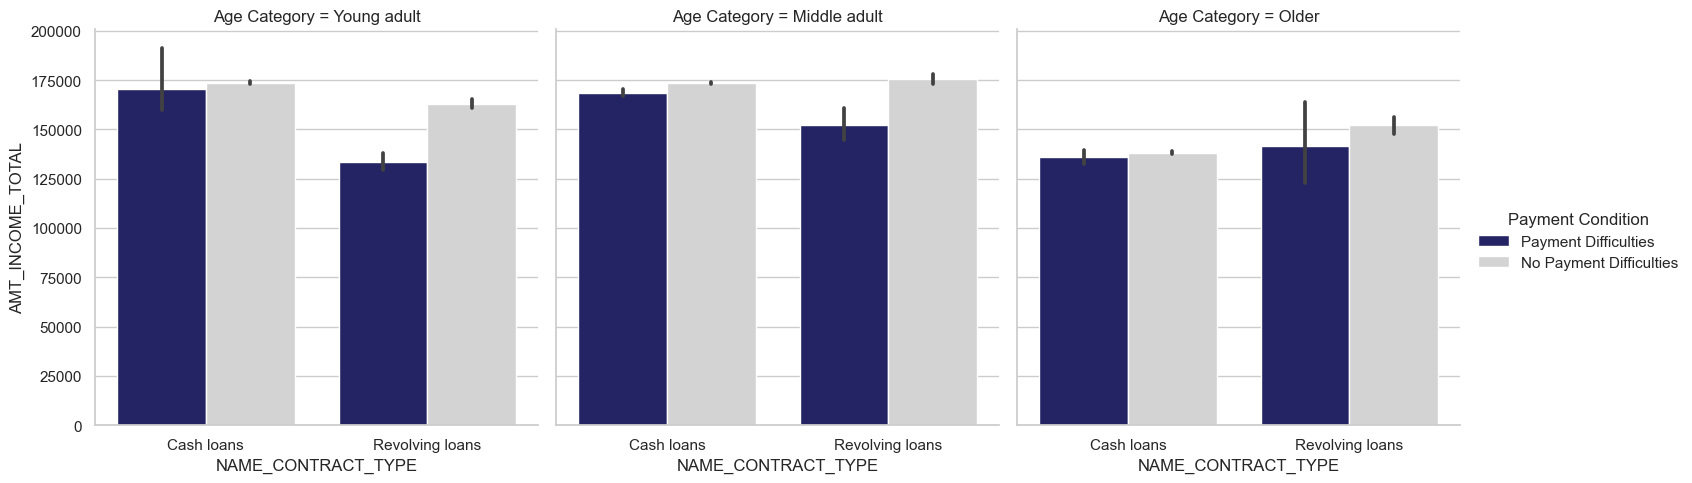

In [44]:
sns.catplot(x = 'NAME_CONTRACT_TYPE', 
            y = 'AMT_INCOME_TOTAL', 
            hue = 'Payment Condition', 
            col = 'Age Category', 
            kind = 'bar', palette = ['midnightblue','lightgrey'],
            data = df_train)


plt.show()

The customers who apply for the most loans here are **Middle-aged customers (40-59)**, followed by **Young Adults (20-39)** and finally old-aged customers (60 and above).

Then the type of loan repayment in **Cash Loans is experiencing a serious problem because there are more nominal than Revolving Loans.** 

It turns out that even the amount of income does not find a significant difference, if we look at the problems of the two types.
So, it can be concluded that even **high or low income is better directed towards revolving loan repayment.**

#### NAME_INCOME_TYPE, AMT_GOODS_PRICE, Payment Condition, FLAG_OWN_REALTY

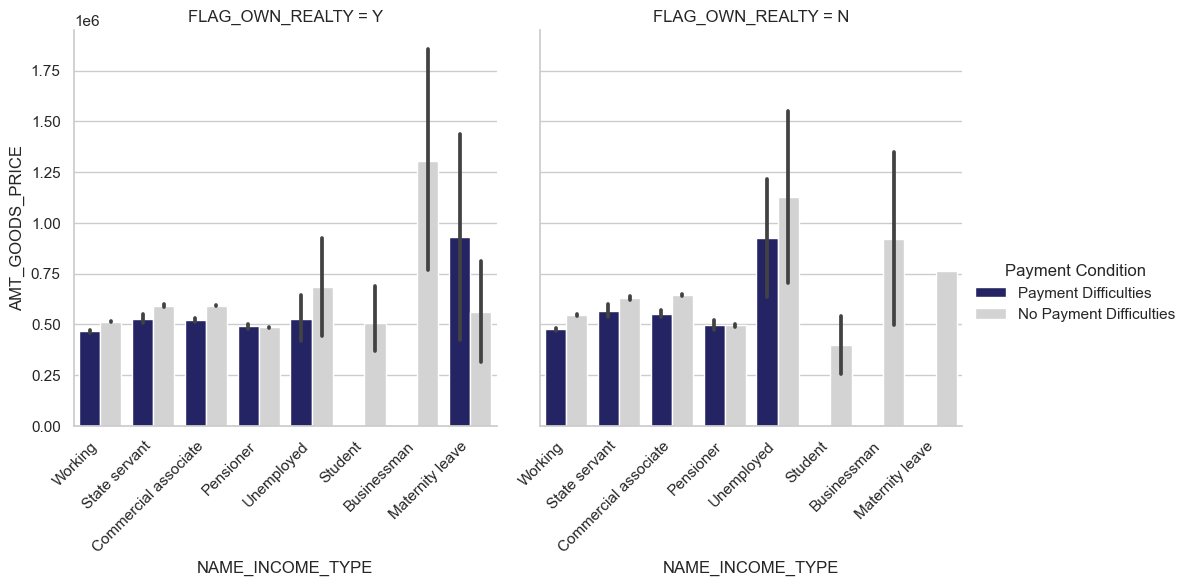

In [45]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE', 
            y = 'AMT_GOODS_PRICE', 
            hue = 'Payment Condition', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = ['midnightblue','lightgrey'],
            data = df_train)
fig.set_xticklabels(rotation=45,horizontalalignment='right')
plt.show()

**Even lending the exact price requested by the customer is problematic.**

Customers who are on **Maternity leave** with <mark>FLAG_OWN_REALTY = Yes</mark> (i.e. have a fixed abode) and customers who are **Unemployed** with <mark>FLAG_OWN_REALTY = No</mark> (i.e. do not have a fixed/rent abode) have **loan repayment problems.**

While the price submitted for the loan application is in accordance with the request by the customer.

#### NAME_HOUSING_TYPE, AMT_CREDIT, Payment Condition, married_stats

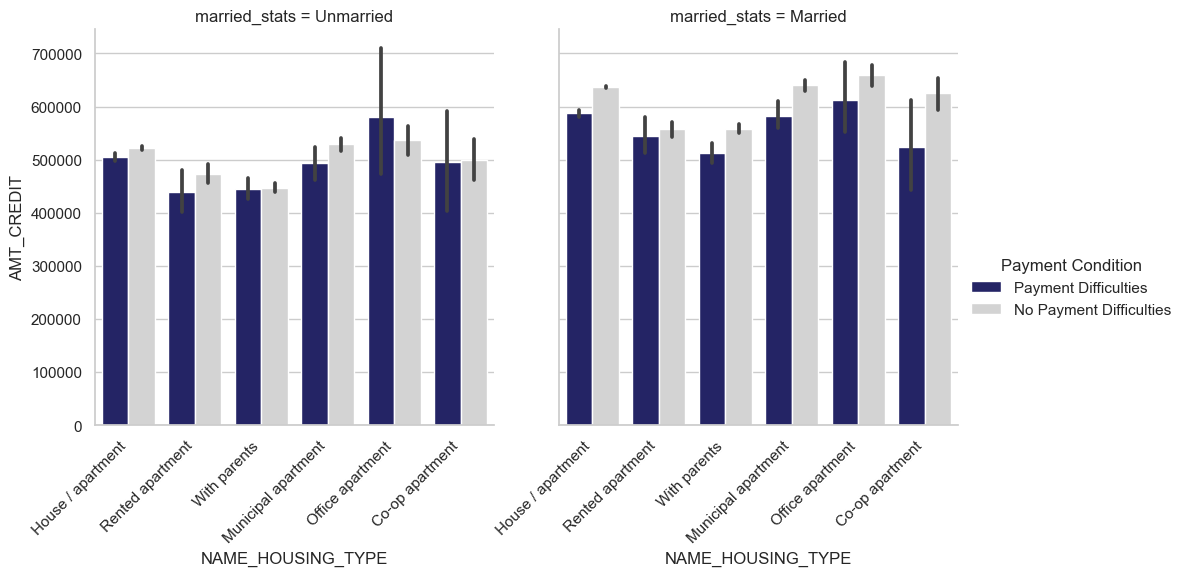

In [46]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE', 
            y = 'AMT_CREDIT', 
            hue = 'Payment Condition', 
            col = 'married_stats', 
            kind = 'bar', palette = ['midnightblue','lightgrey'],
            data = df_train)
fig.set_xticklabels(rotation=45,horizontalalignment='right')
plt.show()

It turns out that **most customers who apply for loans are married and have housing types such as Municipal apartments and Office apartments**,

Then there is a category of **customers who are married and have a type of house, namely Co-op Apartments**, which **has a more significant comparison than the others** because the number of customers who experience problems is far less than those who do not.

#### FLAG_OWN_CAR, AMT_ANNUITY, Payment Condition, children

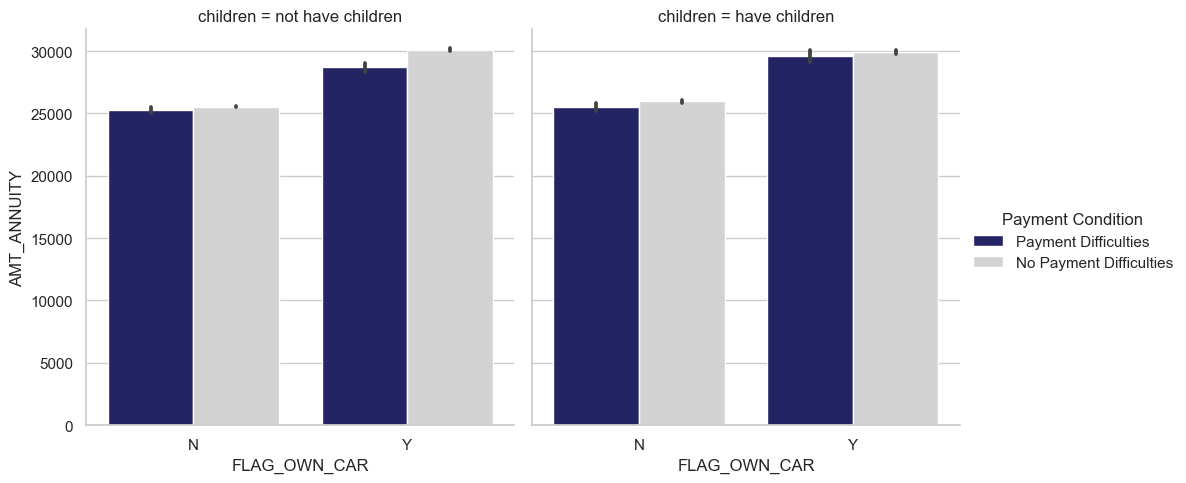

In [47]:
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'AMT_ANNUITY', 
            hue = 'Payment Condition', 
            col = 'children', 
            kind = 'bar', palette = ['midnightblue','lightgrey'],
            data = df_train)
plt.show()

**Customers who own a car apply for loans** that are almost as large and even **make no significant difference** whether these **customers have children or not.**

#### NAME_CONTRACT_TYPE, AMT_CREDIT, AMT_INCOME_TOTAL, Payment Condition, CODE_GENDER

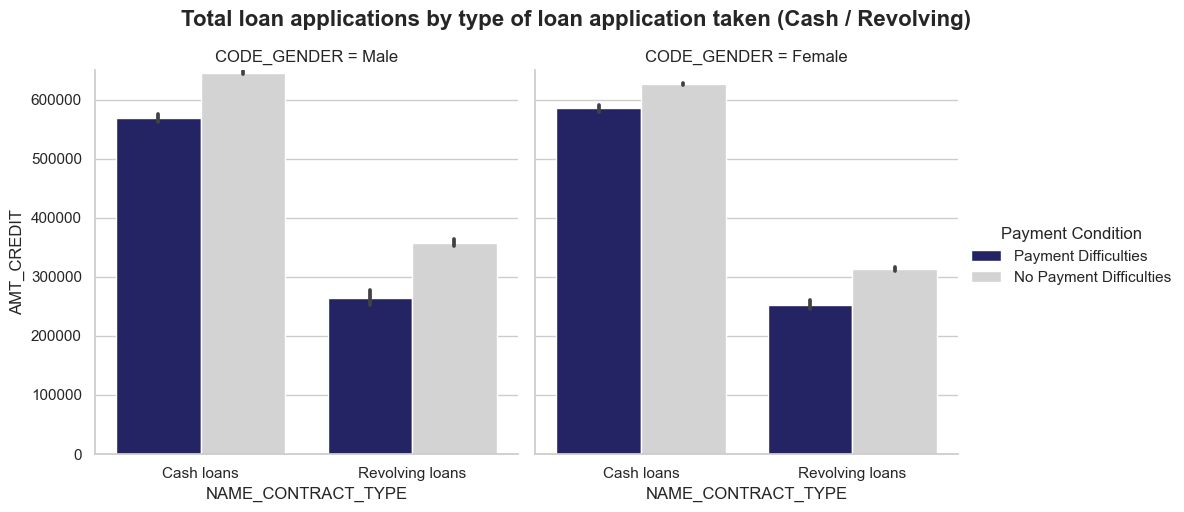

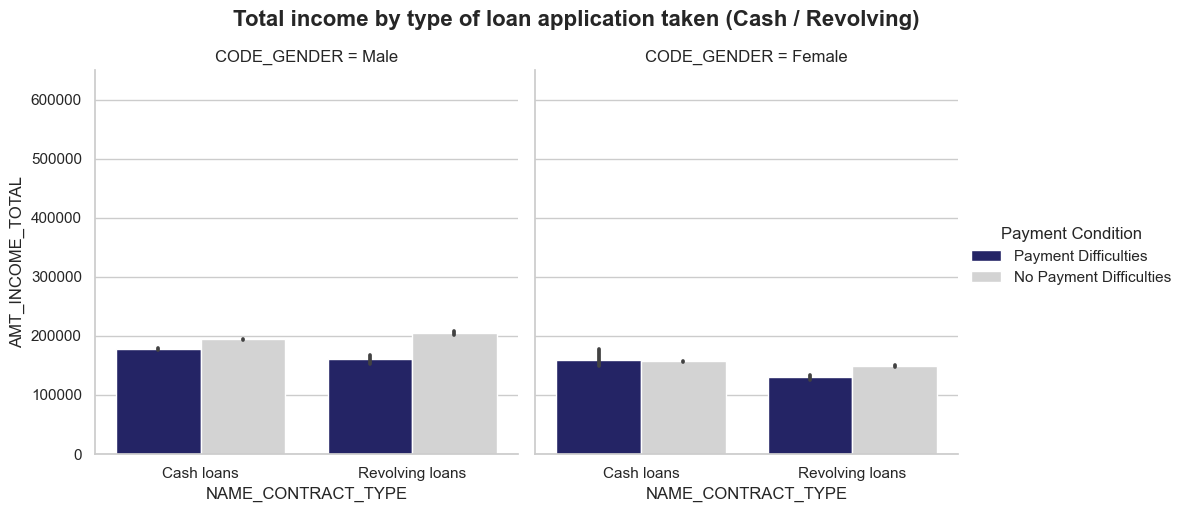

In [48]:
fig = sns.catplot(x='NAME_CONTRACT_TYPE', 
            y='AMT_CREDIT', 
            hue='Payment Condition',
            col ='CODE_GENDER', 
            data=df_train, kind='bar',
            palette=['midnightblue', 'lightgrey'])

fig.fig.suptitle('Total loan applications by type of loan application taken (Cash / Revolving)', y=1.02, fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9)
for ax in fig.axes.flat:
    ax.set_ylim(0, 650000)


ax = sns.catplot(x = 'NAME_CONTRACT_TYPE',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'Payment Condition', 
            col = 'CODE_GENDER', 
            kind = 'bar', palette = ['midnightblue','lightgrey'],
            data = df_train)
ax.fig.suptitle('Total income by type of loan application taken (Cash / Revolving)', y=1.02, fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9)

for ax in ax.axes.flat:
    ax.set_ylim(0, 650000)

plt.show()

The graph above is the type of loan application based on the comparison between total loan applications and total income. 

It can be seen that this **comparison is very unbalanced**, because the **application requests made by customers with cash loans are very far from their total income.**

<mark>So it is not surprising that Cash Loans, as a contract type, are the most problematic..</mark>

#### NAME_CONTRACT_TYPE, AMT_CREDIT, AMT_INCOME_TOTAL, Payment Condition, NAME_INCOME_TYPE

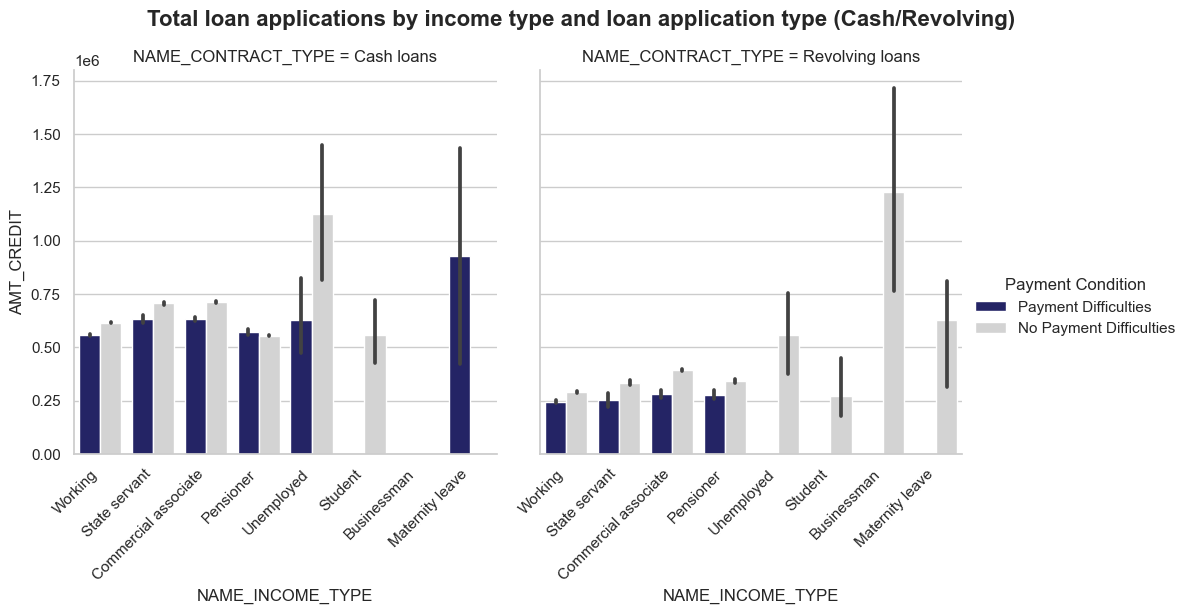

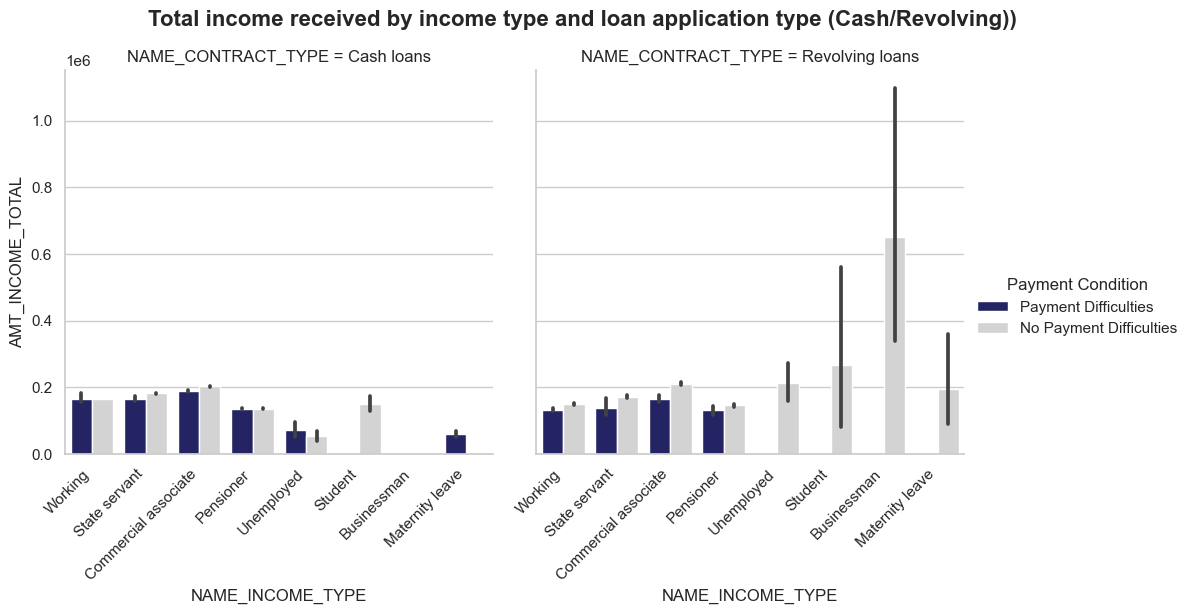

In [49]:
fig = sns.catplot(x='NAME_INCOME_TYPE', 
            y='AMT_CREDIT', 
            hue='Payment Condition',
            col ='NAME_CONTRACT_TYPE', 
            data=df_train, kind='bar',
            palette=['midnightblue', 'lightgrey'])

fig.fig.suptitle('Total loan applications by income type and loan application type (Cash/Revolving)', y=1.02, fontsize=16, fontweight='bold')
for ax in fig.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(top=0.9)



ax = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'Payment Condition', 
            col = 'NAME_CONTRACT_TYPE', 
            kind = 'bar', palette = ['midnightblue','lightgrey'],
            data = df_train)

ax.fig.suptitle('Total income received by income type and loan application type (Cash/Revolving))', y=1.02, fontsize=16, fontweight='bold')
for ax in ax.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(top=0.9)
    
    
plt.show()

There are several types of income that cause the above **chart comparison to be unbalanced**,  namely the **types of income that come from working customers, civil servants, private employees, and retirees.**

**Even worse are those who are not working and on maternity leave.** 

# Data Cleaning

### Detecting Data Duplication

In [50]:
df_train.duplicated().sum()

0

### Detecting Missing Value

In [51]:
any_null = pd.DataFrame(df_train.isnull().sum(),columns = ['null_values'])
any_null['Percentage'] = (any_null['null_values']/len(df_train)) * 100
any_null = any_null.reset_index()
any_null.rename(columns = {'index':'columns'},inplace = True)
any_null = any_null[any_null['Percentage']!=0]

print('There is ',any_null.shape[0], 'columns have missing values')

any_null

There is  67 columns have missing values


,columns,null_values,Percentage
9,AMT_ANNUITY,12,0.003902
10,AMT_GOODS_PRICE,278,0.090403
11,NAME_TYPE_SUITE,1292,0.420148
20,OWN_CAR_AGE,202929,65.990810
27,OCCUPATION_TYPE,96391,31.345545
...,...,...,...
116,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
117,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
118,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
119,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631


<mark>We will remove the feature that have more than 40% null data </mark>

In [52]:
any_null = any_null[any_null['Percentage'] > 40].sort_values(by='Percentage',ascending= False)
any_null.reset_index().drop(columns = 'index')

,columns,null_values,Percentage
0,COMMONAREA_AVG,214865,69.872297
1,COMMONAREA_MEDI,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
4,NONLIVINGAPARTMENTS_MODE,213514,69.432963
5,NONLIVINGAPARTMENTS_AVG,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MEDI,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MODE,210199,68.354953


In [53]:
data = list(any_null['columns'])
df_train = df_train.drop(columns = data)
df_train = df_train.drop(columns = 'SK_ID_CURR')

In [54]:
clm_drop = ['married_stats','children','Payment Condition', 'Age Category']
df_train = df_train.drop(columns = clm_drop)
df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   NAME_CONTRACT_TYPE           307511 non-null  object 
 2   CODE_GENDER                  307511 non-null  object 
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   CNT_CHILDREN                 307511 non-null  int64  
 6   AMT_INCOME_TOTAL             307511 non-null  float64
 7   AMT_CREDIT                   307511 non-null  float64
 8   AMT_ANNUITY                  307499 non-null  float64
 9   AMT_GOODS_PRICE              307233 non-null  float64
 10  NAME_TYPE_SUITE              306219 non-null  object 
 11  NAME_INCOME_TYPE             307511 non-null  object 
 12  NAME_EDUCATION_TYPE          307511 non-null  object 
 13 

In [55]:
still_null = pd.DataFrame(df_train.isnull().sum(),columns = ['null_values'])
still_null['Percentage'] = (still_null['null_values']/len(df_train))


still_null = still_null[(still_null['Percentage']!=0)].sort_values(by='Percentage',ascending= False).reset_index()
still_null.rename(columns = {'index':'columns'},inplace = True)

still_null

,columns,null_values,Percentage
0,OCCUPATION_TYPE,96391,0.313455
1,EXT_SOURCE_3,60965,0.198253
2,AMT_REQ_CREDIT_BUREAU_YEAR,41519,0.135016
3,AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016
4,AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016
5,AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016
6,AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016
7,AMT_REQ_CREDIT_BUREAU_HOUR,41519,0.135016
8,NAME_TYPE_SUITE,1292,0.004201
9,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.003320


In [56]:
null = list(still_null['columns'])

df_train[null].info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   OCCUPATION_TYPE             211120 non-null  object 
 1   EXT_SOURCE_3                246546 non-null  float64
 2   AMT_REQ_CREDIT_BUREAU_YEAR  265992 non-null  float64
 3   AMT_REQ_CREDIT_BUREAU_QRT   265992 non-null  float64
 4   AMT_REQ_CREDIT_BUREAU_MON   265992 non-null  float64
 5   AMT_REQ_CREDIT_BUREAU_WEEK  265992 non-null  float64
 6   AMT_REQ_CREDIT_BUREAU_DAY   265992 non-null  float64
 7   AMT_REQ_CREDIT_BUREAU_HOUR  265992 non-null  float64
 8   NAME_TYPE_SUITE             306219 non-null  object 
 9   DEF_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 10  OBS_60_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 11  DEF_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 12  OBS_30_CNT_SOCIAL_CIRCLE    306490 non-null  float64
 13  EXT_SOURCE_2  

In [57]:
df_train[null]

,OCCUPATION_TYPE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,NAME_TYPE_SUITE,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE
0,Laborers,0.139376,1.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,2.0,2.0,2.0,2.0,0.262949,351000.0,24700.5,1.0,-1134.0
1,Core staff,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Family,0.0,1.0,0.0,1.0,0.622246,1129500.0,35698.5,2.0,-828.0
2,Laborers,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,1.0,-815.0
3,Laborers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,2.0,0.0,2.0,0.650442,297000.0,29686.5,2.0,-617.0
4,Core staff,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,1.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Sales staff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.681632,225000.0,27558.0,1.0,-273.0
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.115992,225000.0,12001.5,1.0,0.0
307508,Managers,0.218859,1.0,0.0,1.0,0.0,0.0,1.0,Unaccompanied,0.0,6.0,0.0,6.0,0.535722,585000.0,29979.0,1.0,-1909.0
307509,Laborers,0.661024,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.514163,319500.0,20205.0,2.0,-322.0


In [58]:
categ_cols = df_train[df_train[null].select_dtypes(include=['object']).columns]
num_cols = df_train[df_train[null].select_dtypes(include=['int64','float64']).columns]

num_cols 

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,DEF_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE
0,0.139376,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.262949,351000.0,24700.5,1.0,-1134.0
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.622246,1129500.0,35698.5,2.0,-828.0
2,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,1.0,-815.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,2.0,0.650442,297000.0,29686.5,2.0,-617.0
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,1.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.681632,225000.0,27558.0,1.0,-273.0
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.115992,225000.0,12001.5,1.0,0.0
307508,0.218859,1.0,0.0,1.0,0.0,0.0,1.0,0.0,6.0,0.0,6.0,0.535722,585000.0,29979.0,1.0,-1909.0
307509,0.661024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514163,319500.0,20205.0,2.0,-322.0


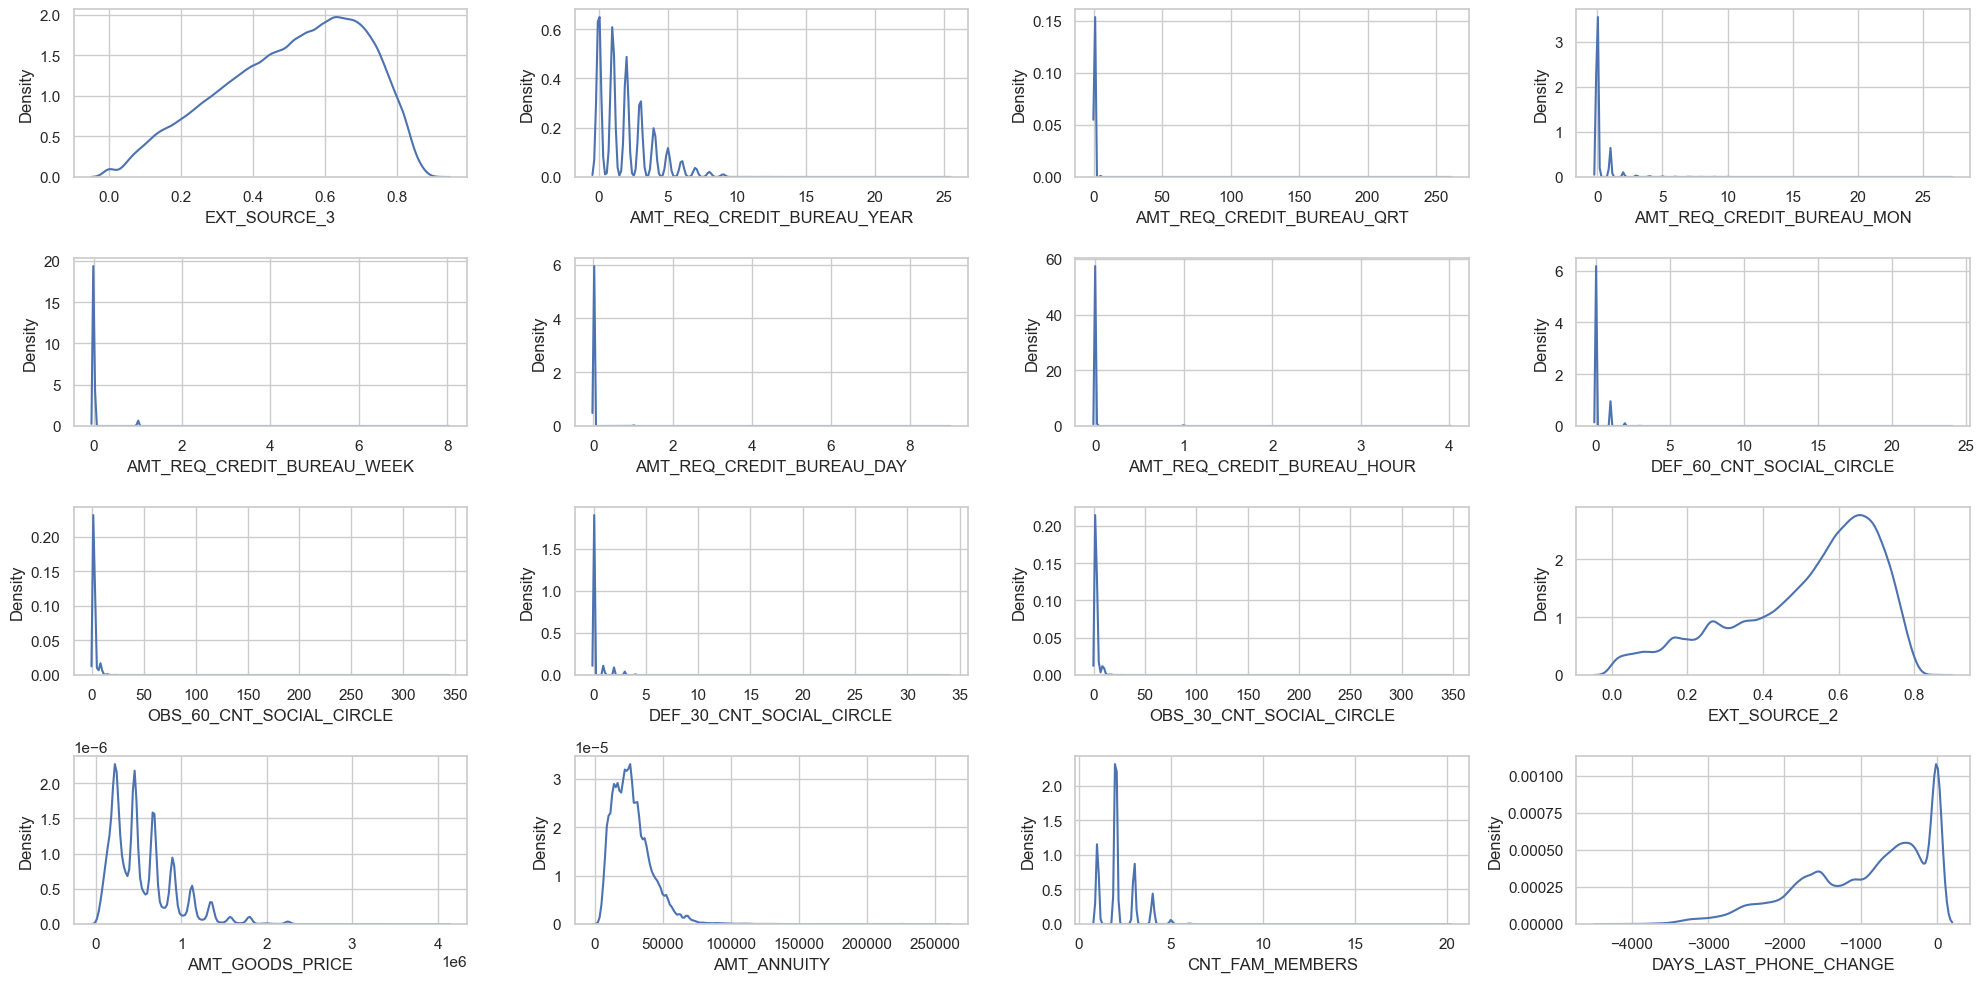

In [59]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num_cols.columns, 1):
    plt.subplot(5,4,i)
    sns.kdeplot(data=num_cols, x=num_cols[column])
    plt.tight_layout()

plt.show()

From each column of the graph above, there is a data distribution that shows the **density of values in each column.**
Then if you pay further attention to the lines that make up all these graphs, there is one point that is the most towering which is at 0 on the x-axis, besides that there is one column that has x less than 0. 

The conclusion is that the distribution of the **numerical features mentioned above is skewed**, so the missing values in those features will be accounted for by the median

The first thing to do is we will perform operations on **columns that have values less than 0, we will times -1** so that if we **standardize and normalize with other values, it doesn't be far different.**

In [60]:
categorical_cols = [cname for cname in df_train.columns if df_train[cname].dtype == 'object']
numerical_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['int64', 'float64']]

neg_columns = df_train[numerical_cols].columns[(df_train[numerical_cols]<0).any()].tolist()
df_train[neg_columns] = df_train[neg_columns] * -1

df_train[numerical_cols]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,637,3648.0,2120,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1188,1186.0,291,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,225,4260.0,2531,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,3039,9833.0,2437,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,52
4,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,3038,4311.0,3458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,236,8456.0,1982,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,25
307507,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-365243,4388.0,4090,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,56
307508,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,7921,6737.0,5150,...,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,41
307509,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,4786,2562.0,931,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,32


Then, we will <mark>fill in the **missing values in the numeric columns with the median** and in the **categorical columns with the mode.**</mark>

In [61]:
cat = []
for i in null:
    if df_train[i].dtype == 'object':
        df_train[i].fillna(df_train[i].mode()[0],inplace = True)
    else:
        df_train[i].fillna(df_train[i].median(), inplace = True)
        
        
print('Missing Values Status :', df_train.isnull().values.any())
aft_imp = pd.DataFrame(df_train.isnull().sum().sort_values(), columns = ['Total Null Values'])
aft_imp['Percentage'] = (aft_imp['Total Null Values']/len(df_train))*100
aft_imp.sort_values(by='Percentage', ascending = False).reset_index()

Missing Values Status : False


,index,Total Null Values,Percentage
0,TARGET,0,0.0
1,FLAG_DOCUMENT_8,0,0.0
2,DAYS_EMPLOYED,0,0.0
3,AMT_CREDIT,0,0.0
4,NAME_CONTRACT_TYPE,0,0.0
...,...,...,...
67,AMT_REQ_CREDIT_BUREAU_HOUR,0,0.0
68,AMT_REQ_CREDIT_BUREAU_DAY,0,0.0
69,AMT_REQ_CREDIT_BUREAU_WEEK,0,0.0
70,AMT_REQ_CREDIT_BUREAU_MON,0,0.0


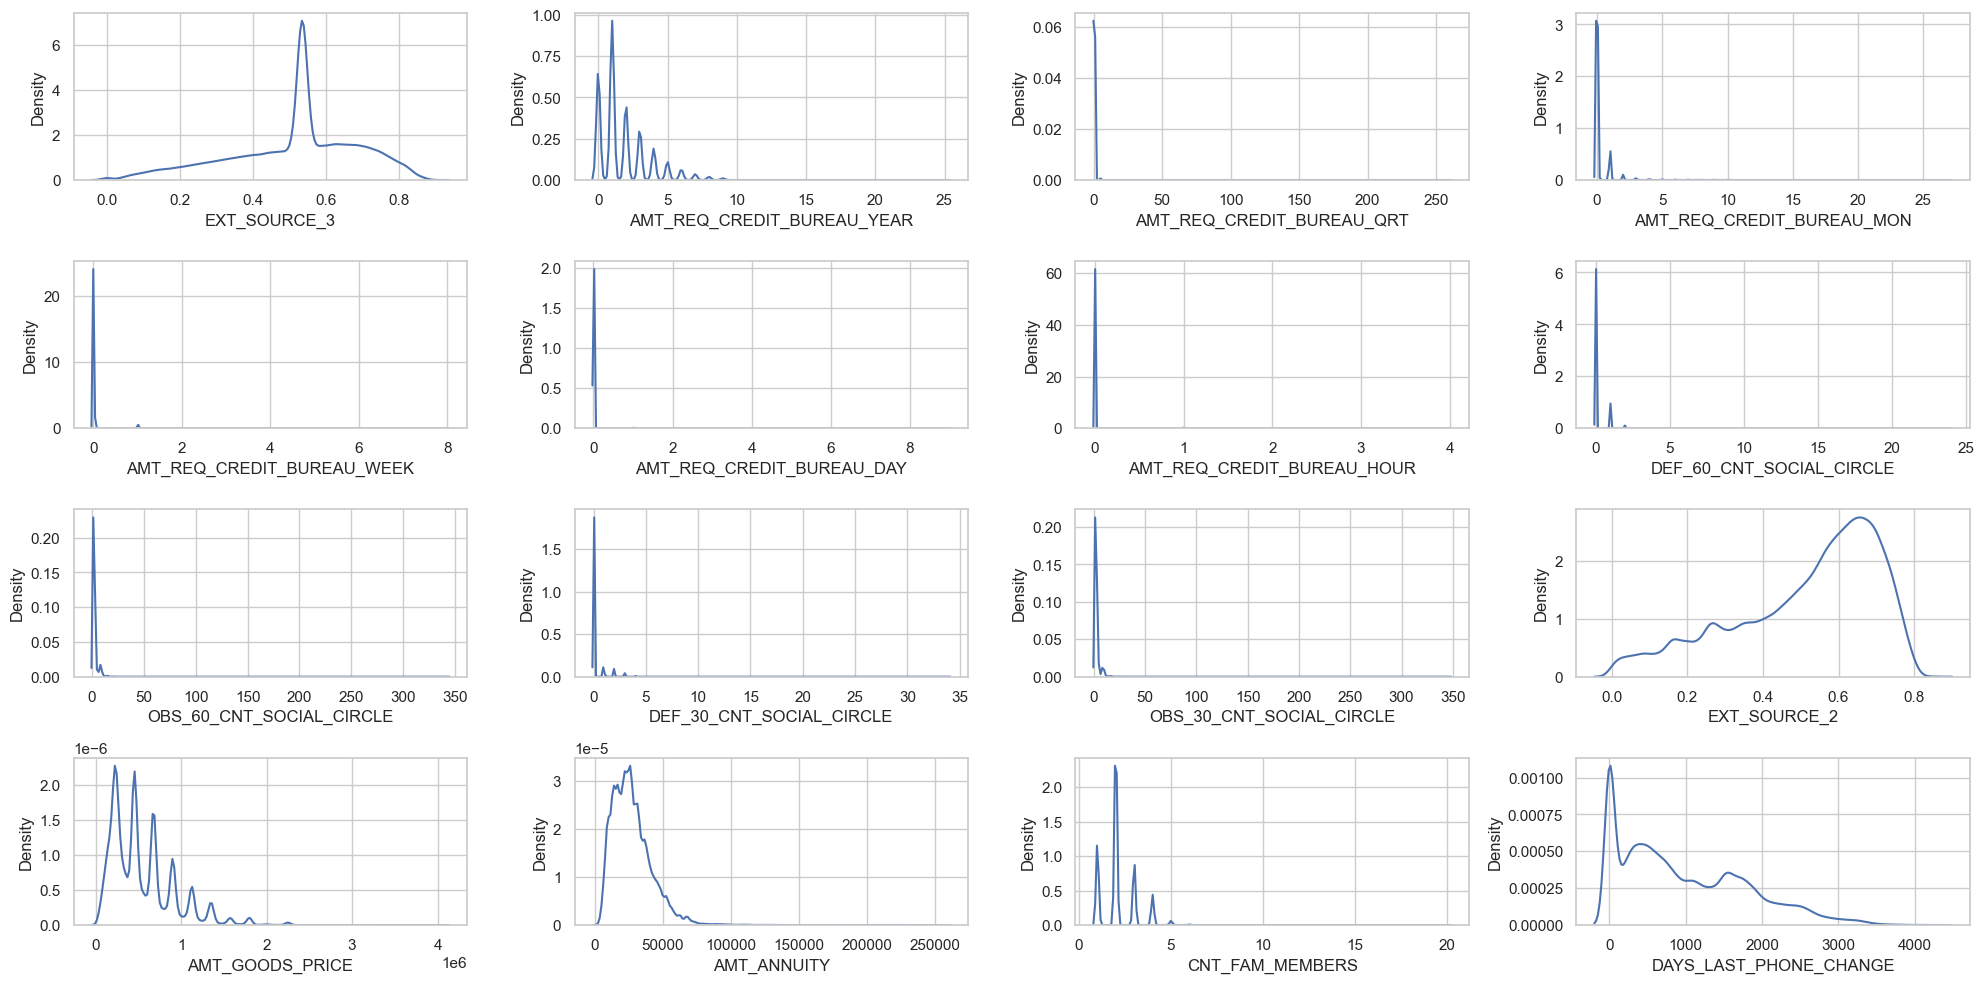

In [62]:
num_cols_1 = num_cols.columns.tolist()
non_null_val = df_train[num_cols_1]

plt.figure(figsize=(20,12))

for i, column in enumerate (non_null_val.columns, 1):
    plt.subplot(5,4,i)
    sns.kdeplot(data=non_null_val, x=non_null_val[column])
    plt.tight_layout()

plt.show()

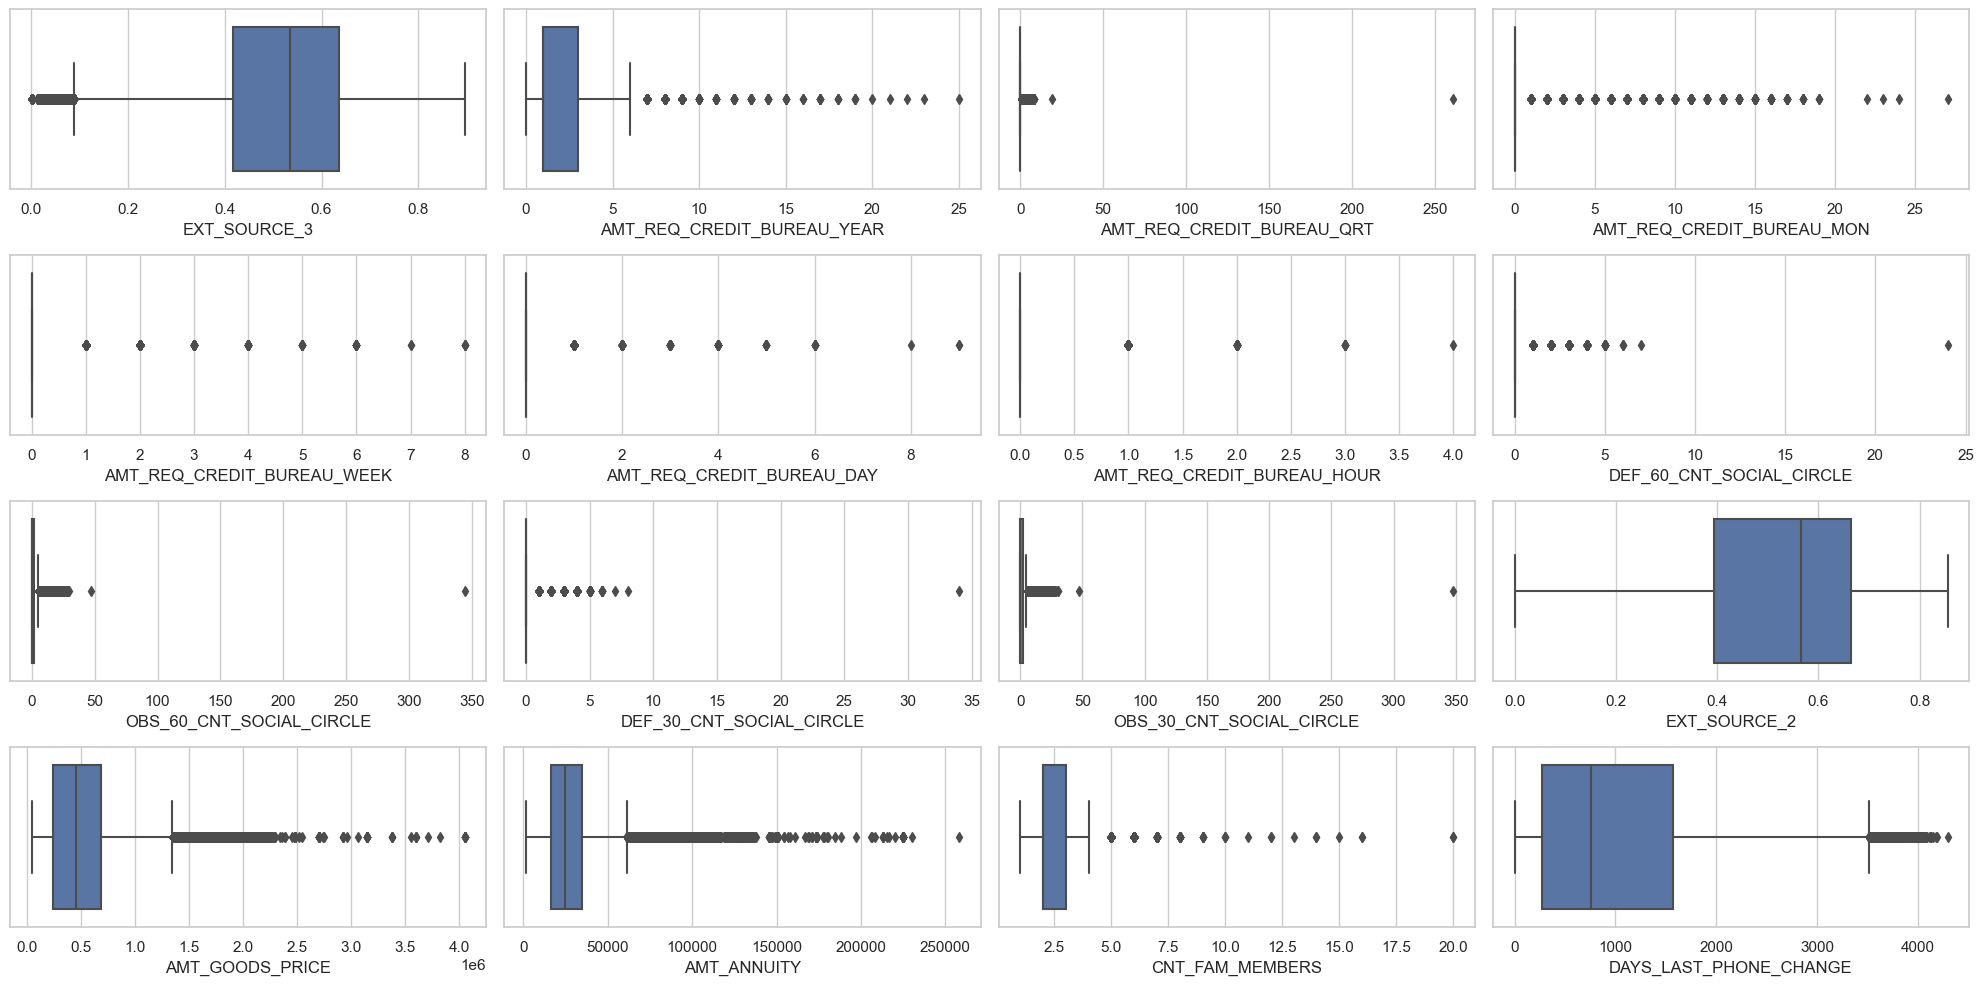

In [63]:
plt.figure(figsize=(20,12))

for i, column in enumerate (non_null_val.columns, 1):
    plt.subplot(5,4,i)
    sns.boxplot(data=non_null_val, x=non_null_val[column])
    plt.tight_layout()

plt.show()

<mark>Outliers on the numerical features mentioned above will not be removed because there may be insights that can be drawn from these outliers.</mark>

# Numeric Data Type

### Feature Transformation

In [64]:
numeric = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
df_train[numeric]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,637,3648.0,2120,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1188,1186.0,291,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,225,4260.0,2531,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,3039,9833.0,2437,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,3038,4311.0,3458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,236,8456.0,1982,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25
307507,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-365243,4388.0,4090,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,56
307508,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,7921,6737.0,5150,...,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,41
307509,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,4786,2562.0,931,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,32


<mark> Transform numeric columns that have unique values greater than 2 with StandardScaler so that the values of a feature are scaled similarly and allow for improved performance of a machine learning model.</mark>

In [65]:
num_cols = df_train.select_dtypes(exclude = 'object')
num_list = list(num_cols.columns)

uniq = pd.DataFrame(num_cols.nunique(),columns = ['Total_unique']).reset_index()
uniq = uniq.rename(columns = {'index':'Columns'})

num_a = []
num_b = []
for i, y in enumerate(uniq.Columns):
    if uniq['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

In [66]:
#Standardization
scaler = preprocessing.StandardScaler().fit(df_train[num_a])
df_train[num_a] = scaler.transform(df_train[num_a])

df_train[numeric]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,1,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,0.456215,-0.379837,-0.579154,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-0.440926,-1.542169
1,0,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,0.460115,-1.078697,-1.790855,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331,0.130831
2,0,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,0.453299,-0.206116,-0.306869,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331,0.716381
3,0,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,0.473217,1.375829,-0.369143,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-0.440926,0.716381
4,0,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,0.473210,-0.191639,0.307263,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331,0.883681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,-0.577538,-0.047646,-0.855489,0.031015,-0.848433,0.845396,0.453377,0.984955,-0.670578,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-0.440926,-1.542169
307507,0,-0.577538,-0.408219,-0.818594,-1.042333,-0.848433,0.310593,-2.133617,-0.169782,0.725959,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-0.440926,1.050981
307508,0,-0.577538,-0.066623,0.195379,0.198056,0.126415,-1.147120,0.507774,0.497002,1.428203,...,0,0,0,12.747224,-0.058766,-0.155837,0.897175,-0.30862,-0.440926,-0.203769
307509,1,-0.577538,0.009287,-0.568757,-0.476318,-0.592535,-1.124635,0.485583,-0.688107,-1.366859,...,0,0,0,-0.070987,-0.058766,-0.155837,-0.269947,-0.30862,-1.007331,-0.956619


# Object Data type

### Feature Transformation

In [67]:
cat_cols = df_train.select_dtypes(include = 'object')
cat_list = list(cat_cols.columns)

uniq_cat = pd.DataFrame(cat_cols.nunique(),columns = ['Total_unique']).reset_index()
uniq_cat = uniq_cat.rename(columns = {'index':'Columns'})

uniq_cat

,Columns,Total_unique
0,NAME_CONTRACT_TYPE,2
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,NAME_TYPE_SUITE,7
5,NAME_INCOME_TYPE,8
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,6
8,NAME_HOUSING_TYPE,6
9,OCCUPATION_TYPE,18


It can be seen in the table that the <mark>ORGANIZATION_TYPE, & OCCUPATION_TYPE</mark> columns have more than **15 unique numbers so we will drop those columns** and **perform Label Encoding & One Hot Encoding.**

Because <mark>Label Encoding and One Hot Encoding do not work well if there are many unique values (High Cardinality).</mark>

In [68]:
df_train = df_train.drop(columns = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'])

cols_cat = df_train.select_dtypes(include = 'object')
list_cat = list(cols_cat.columns)

cat_uniq = pd.DataFrame(cols_cat.nunique(),columns = ['Total_unique']).reset_index()
cat_uniq = cat_uniq.rename(columns = {'index':'Columns'})

cat_uniq

,Columns,Total_unique
0,NAME_CONTRACT_TYPE,2
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,NAME_TYPE_SUITE,7
5,NAME_INCOME_TYPE,8
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,6
8,NAME_HOUSING_TYPE,6
9,WEEKDAY_APPR_PROCESS_START,7


In [69]:
obj_1 = []
obj_2 = []
for i,y in enumerate(cat_uniq['Columns']):
    if cat_uniq['Total_unique'][i] <= 2:
        obj_1.append(y)
    else:
        obj_2.append(y)

In [70]:
obj_1

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [71]:
obj_2

['NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START']

### Label Encoding 

In [72]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
for cat in obj_1:
    df_train[cat]= label_encoder.fit_transform(df_train[cat])
    
df_train[obj_1]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,1,0,1
1,0,0,0,0
2,1,1,1,1
3,0,0,0,1
4,0,1,0,1
...,...,...,...,...
307506,0,1,0,0
307507,0,0,0,1
307508,0,0,0,1
307509,0,0,0,1


### One Hot Encoding

In [73]:
for cat in obj_2:
    onehots = pd.get_dummies(df_train[cat], prefix = cat)
    df_train = df_train.join(onehots)
    
df_train = df_train.drop(columns = obj_2)

In [74]:
df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 103 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    TARGET                                             int64  
 1    NAME_CONTRACT_TYPE                                 int32  
 2    CODE_GENDER                                        int32  
 3    FLAG_OWN_CAR                                       int32  
 4    FLAG_OWN_REALTY                                    int32  
 5    CNT_CHILDREN                                       float64
 6    AMT_INCOME_TOTAL                                   float64
 7    AMT_CREDIT                                         float64
 8    AMT_ANNUITY                                        float64
 9    AMT_GOODS_PRICE                                    float64
 10   REGION_POPULATION_RELATIVE                         float64
 11   DAYS_EMPLOYED                        

In [75]:
col_int = [col for col in df_train.columns if df_train[col].dtypes == 'int32']
df_train[col_int] = df_train[col_int].astype('int64')
col_bool = [col for col in df_train.columns if df_train[col].dtypes == 'bool']


#own_car['FLAG_OWN_CAR'] = own_car['FLAG_OWN_CAR'].replace(['Y', 'N'], ['Yes','No'])
df_train[col_bool] = df_train[col_bool].astype('int64')

df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 103 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    TARGET                                             int64  
 1    NAME_CONTRACT_TYPE                                 int64  
 2    CODE_GENDER                                        int64  
 3    FLAG_OWN_CAR                                       int64  
 4    FLAG_OWN_REALTY                                    int64  
 5    CNT_CHILDREN                                       float64
 6    AMT_INCOME_TOTAL                                   float64
 7    AMT_CREDIT                                         float64
 8    AMT_ANNUITY                                        float64
 9    AMT_GOODS_PRICE                                    float64
 10   REGION_POPULATION_RELATIVE                         float64
 11   DAYS_EMPLOYED                        

Feature Selection
---

In [76]:
X = df_train.drop(['TARGET'], axis = 1)
y = df_train['TARGET']

In [77]:
num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

negative = X[num_cols].columns[(X[num_cols]<0).any()].tolist()
X[X['CNT_CHILDREN'] < 0].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0,1,0,1,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,...,0,0,0,0,1,0,0,0,0,0
2,1,1,1,1,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,1,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,...,0,0,0,0,0,0,0,1,0,0


In [78]:
X.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 102 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    NAME_CONTRACT_TYPE                                 int64  
 1    CODE_GENDER                                        int64  
 2    FLAG_OWN_CAR                                       int64  
 3    FLAG_OWN_REALTY                                    int64  
 4    CNT_CHILDREN                                       float64
 5    AMT_INCOME_TOTAL                                   float64
 6    AMT_CREDIT                                         float64
 7    AMT_ANNUITY                                        float64
 8    AMT_GOODS_PRICE                                    float64
 9    REGION_POPULATION_RELATIVE                         float64
 10   DAYS_EMPLOYED                                      float64
 11   DAYS_REGISTRATION                    

In [79]:
# feature selection

from sklearn.pipeline import Pipeline

# Create SelectKBest instance with f_classif scoring function
selector = SelectKBest(score_func=f_classif, k=5)  # You can change k to the number of features you want to select

# Fit the selector to your preprocessed data
selector.fit(X, y)

dfscores = pd.DataFrame(selector.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that are highly dependent on the target :\n')
featureScores.sort_values(by=['Score'], ascending=False, inplace = True)
best_scores = featureScores
best_scores = best_scores.reset_index().drop('index', axis=1)
best_scores.head(10)

The features that are highly dependent on the target :



,Features,Score
0,EXT_SOURCE_2,8109.633923
1,EXT_SOURCE_3,7659.288339
2,Age,1893.726378
3,REGION_RATING_CLIENT_W_CITY,1144.461405
4,REGION_RATING_CLIENT,1070.491250
5,NAME_INCOME_TYPE_Working,1019.404570
6,NAME_EDUCATION_TYPE_Higher education,988.031888
7,DAYS_LAST_PHONE_CHANGE,940.478790
8,CODE_GENDER,923.285127
9,DAYS_ID_PUBLISH,816.396507


**This feature calculates the F value between each feature and the target variable**, which measures the linear dependency between the two variables. **Features that are highly dependent on the target variable will have a high value.**

The following columns have a high dependency on the <mark>TARGET</mark> :
1. EXT_SOURCE_2
2. EXT_SOURCE_3
3. Age
4. REGION_RATING_CLIENT_W_CITY
5. NAME_INCOME_TYPE_WORKING

# Transformation Data

 Because **this data is very imbalance, it will be transformed to equalize the data by using** <mark>Oversampling & Undersampling</mark> so that the application of machine learning can perform well on the data

### Oversampling

In [80]:
oversampling = SMOTE(random_state = 2)
X_over, y_over = oversampling.fit_resample(X,y.ravel())
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size = 0.8, test_size = 0.2, random_state = 42)

In [81]:
class_over = pd.Series(y.value_counts())
class_over = pd.DataFrame({'Target': class_over.index, 'Count':class_over.values})
class_over['Percentage'] = round((class_over['Count']/sum(class_over['Count'])) * 100, 2)


class_over_1 = pd.Series(y_over).value_counts()
class_over_1 = class_over_1.reindex(index = [0,1])
class_over_1 = pd.DataFrame({'Target': class_over_1.index, 'Count' : class_over_1.values})
class_over_1['Percentage'] = round((class_over_1['Count']/sum(class_over['Count'])) * 100, 2)

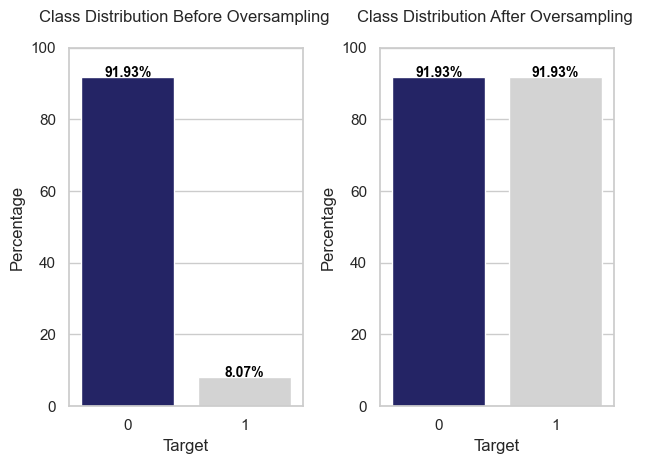

In [82]:
# Bar plot for class distribution before SMOTE
plt.subplot(1, 2, 1)
ax = sns.barplot(data=class_over, x='Target', y='Percentage', palette=['midnightblue', 'lightgrey'])
plt.title('Class Distribution Before Oversampling \n')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.ylim(0,100)
for p, percentage_value in zip(ax.patches, class_over['Percentage']):
    height = p.get_height() + 0.001  # Add small offset to the height
    ax.text(p.get_x() + p.get_width() / 2., height,
            '{:.2f}%'.format(percentage_value),
            ha="center", va="baseline", fontsize=10, color='black', fontweight='bold')

# Bar plot for class distribution after SMOTE
plt.subplot(1, 2, 2)
ax_1 = sns.barplot(data=class_over_1, x='Target', y='Percentage', palette=['midnightblue', 'lightgrey'])
plt.title('Class Distribution After Oversampling \n')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.ylim(0,100)
for p, percentage_value in zip(ax_1.patches, class_over_1['Percentage']):
    height = p.get_height() + 0.001  # Add small offset to the height
    ax_1.text(p.get_x() + p.get_width() / 2., height,
            '{:.2f}%'.format(percentage_value)
            ha="center", va="baseline", fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

It can be seen from the graph that the **oversampling transformation on the Target** with category = <mark> 1(Payment Difficulties)</mark> is **equalized with** category = <mark>0 (No Payment Difficulties)</mark>, **so that the data in the table becomes more than before**.

### Undersampling

In [83]:
undersampling = RandomUnderSampler(random_state=42)
X_under, y_under = undersampling.fit_resample(X, y.ravel())

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_under, y_under, train_size = 0.8, test_size = 0.2, random_state = 42)

In [84]:
class_under = pd.Series(y.value_counts())
class_under = pd.DataFrame({'Target': class_under.index, 'Count':class_under.values})
class_under['Percentage'] = round((class_under['Count']/sum(class_under['Count'])) * 100, 2)


class_under_1 = pd.Series(y_under).value_counts()
class_under_1 = class_under_1.reindex(index = [0,1])
class_under_1 = pd.DataFrame({'Target': class_under_1.index, 'Count' : class_under_1.values})
class_under_1['Percentage'] = round((class_under_1['Count']/sum(class_under['Count'])) * 100, 2)

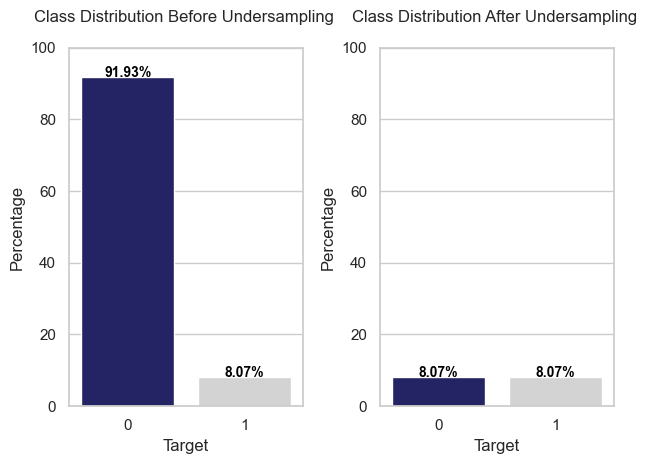

In [85]:
# Bar plot for class distribution before RandomUnderSampler
plt.subplot(1, 2, 1)
ty = sns.barplot(data=class_under, x='Target', y='Percentage', palette=['midnightblue', 'lightgrey'])
plt.title('Class Distribution Before Undersampling \n')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.ylim(0,100)
for p, percentage_value in zip(ty.patches, class_under['Percentage']):
    height = p.get_height() + 0.001  # Add small offset to the height
    ty.text(p.get_x() + p.get_width() / 2., height,
            '{:.2f}%'.format(percentage_value),
            ha="center", va="baseline", fontsize=10, color='black', fontweight='bold')

# Bar plot for class distribution after RandomUnderSampler
plt.subplot(1, 2, 2)
ty_1 = sns.barplot(data=class_under_1, x='Target', y='Percentage', palette=['midnightblue', 'lightgrey'])
plt.title('Class Distribution After Undersampling \n')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.ylim(0,100)
for p, percentage_value in zip(ty_1.patches, class_under_1['Percentage']):
    height = p.get_height() + 0.001  # Add small offset to the height
    ty_1.text(p.get_x() + p.get_width() / 2., height,
            '{:.2f}%'.format(percentage_value),
            ha="center", va="baseline", fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

It can be seen from the graph that the **undersampling transformation on the Target** with category = <mark>0 (Payment Difficulty)</mark> is equalized with **category = <mark>1 (No payment difficulty)</mark>, so that there is less data in the table than before.

# Machine Learning 

Here are some alghoritms that will be tested:

1. <mark>Logistic Regression</mark>
2. <mark>Random Forest</mark>
3. <mark>XGBoost</mark>
4. <mark>K-Nearest Neighbor</mark>

In [86]:
def confusionmatrix(y_test,predict, text):
    cf_matrix = confusion_matrix(y_test, predict)
    conf_df = pd.DataFrame ((cf_matrix), index = ('No Payment Difficulties', 'Payment Difficulties'), columns = ('No Payment Difficulties', 'Payment Difficulties'))
    
    
    #plot confusion matrix
    plt.figure(figsize = (10,5))
    matrix = sns.heatmap(conf_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Blues')
    matrix.yaxis.set_ticklabels(matrix.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14, va = 'center')
    matrix.xaxis.set_ticklabels(matrix.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14, va = 'center')
    matrix.tick_params(axis = 'x', pad = 20)
    
    plt.title('Confusion Matrix for Training Model\n({})\n'.format(str(text)), fontsize=18, color='black')
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()
    
# form confusion matrix as a dataFrame


## 1. Logistic Regression 

### Oversampling Data

D:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.87      0.97      0.92     56536
           1       0.97      0.85      0.91     56539

    accuracy                           0.91    113075
   macro avg       0.92      0.91      0.91    113075
weighted avg       0.92      0.91      0.91    113075



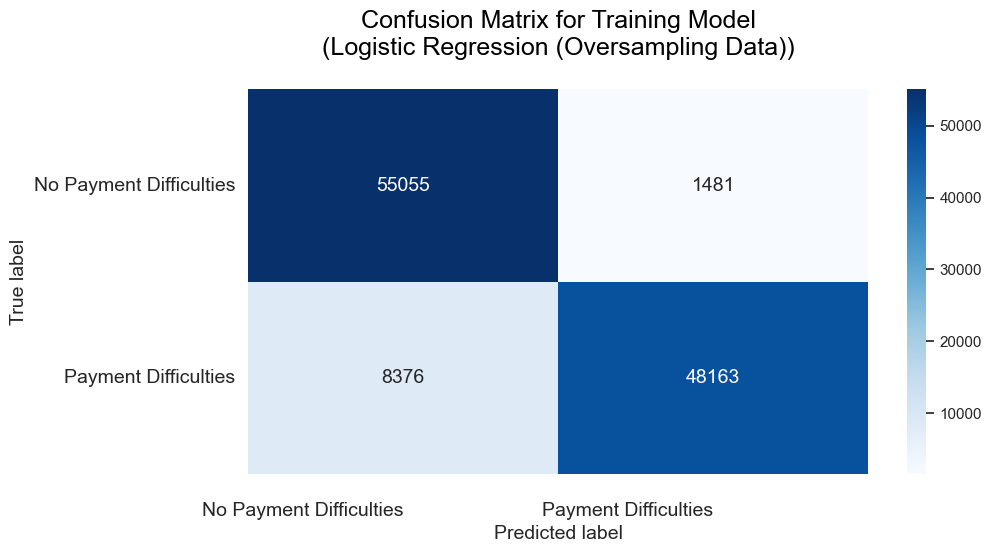

In [87]:
log_reg_1 = LogisticRegression()
log_reg_1.fit(X_train, y_train.ravel())
predicto_1 = log_reg_1.predict(X_test)
  
# print classification report
print(classification_report(y_test, predicto_1))
confusionmatrix(y_test,predicto_1, 'Logistic Regression (Oversampling Data)')

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    226150
           1       0.97      0.85      0.91    226147

    accuracy                           0.91    452297
   macro avg       0.92      0.91      0.91    452297
weighted avg       0.92      0.91      0.91    452297



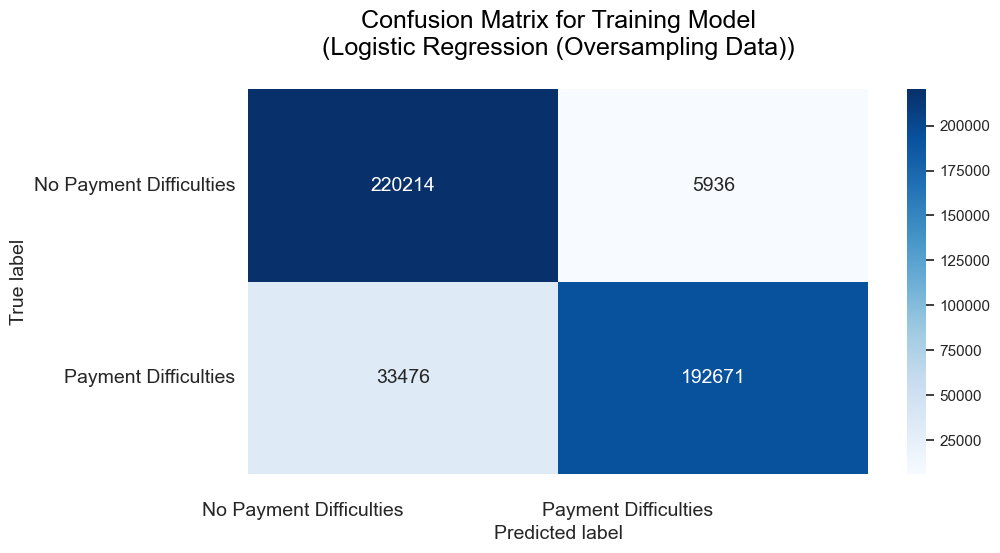

In [88]:
predicto_2 = log_reg_1.predict(X_train)
  
# print classification report
print(classification_report(y_train, predicto_2))
confusionmatrix(y_train,predicto_2, 'Logistic Regression (Oversampling Data)')

In [89]:
predlog_train=round(log_reg_1.score(X_train,y_train)*100,2)
predlog_test=round(log_reg_1.score(X_test,y_test)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy : {} %".format(predlog_train))

Test Accuracy: 91.28 %
Training Accuracy : 91.29 %


It can be seen that:

- Logistic regression model with oversampling data gives 90.5 % correct results.

- There is 0.1% error margin.

### Undersampling Data

D:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.68      0.69      0.68      4953
           1       0.68      0.67      0.68      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



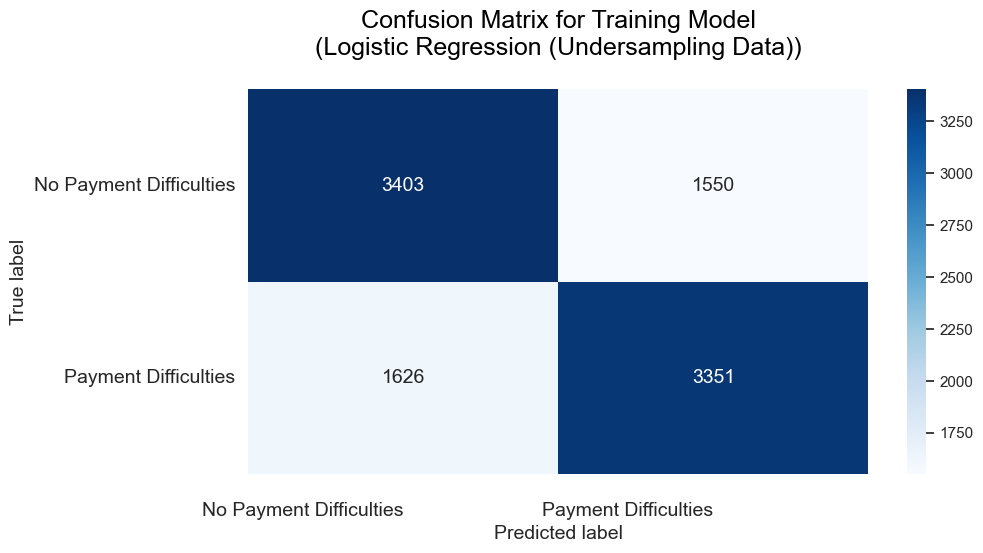

In [90]:
log_reg_2 = LogisticRegression()
log_reg_2.fit(X_train1, y_train1.ravel())
predictu_1 = log_reg_2.predict(X_test1)
  
# print classification report
print(classification_report(y_test1, predictu_1))
confusionmatrix(y_test1,predictu_1, 'Logistic Regression (Undersampling Data)')

              precision    recall  f1-score   support

           0       0.68      0.69      0.68     19872
           1       0.68      0.67      0.68     19848

    accuracy                           0.68     39720
   macro avg       0.68      0.68      0.68     39720
weighted avg       0.68      0.68      0.68     39720



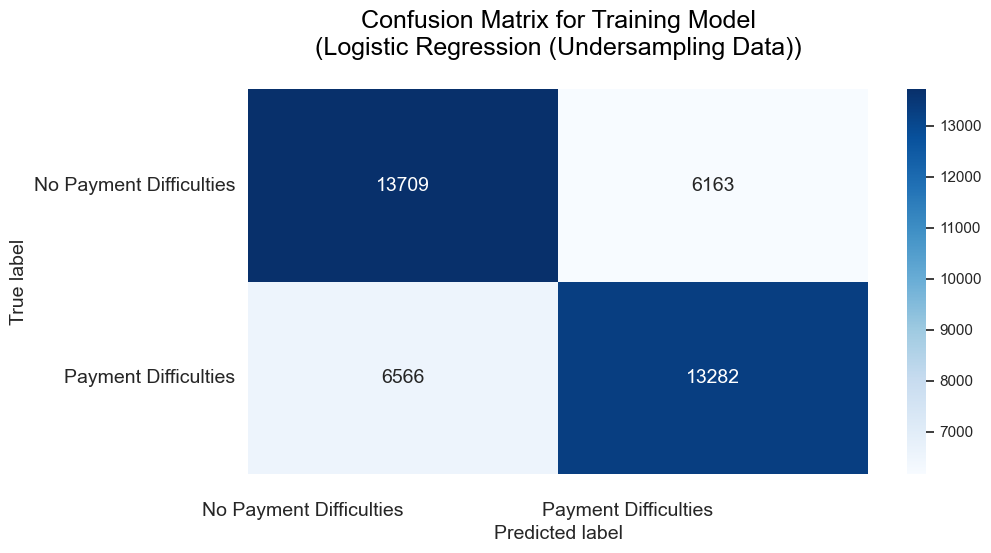

In [91]:
predictu_2 = log_reg_2.predict(X_train1)
  
# print classification report
print(classification_report(y_train1, predictu_2))
confusionmatrix(y_train1,predictu_2, 'Logistic Regression (Undersampling Data)')

In [92]:
predlog_train=round(log_reg_2.score(X_train1,y_train1)*100,2)
predlog_test=round(log_reg_2.score(X_test1,y_test1)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuaracy: {} %".format(predlog_train))

Test Accuracy: 68.02 %
Training Accuaracy: 67.95 %


It can be seen that:

- Logistic regression model with undersampling data gives 67.95 % correct results.

- There is 0.07% error margin.

## 2. Random Forest 

### Oversampling Data

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56536
           1       0.99      0.92      0.95     56539

    accuracy                           0.96    113075
   macro avg       0.96      0.96      0.96    113075
weighted avg       0.96      0.96      0.96    113075



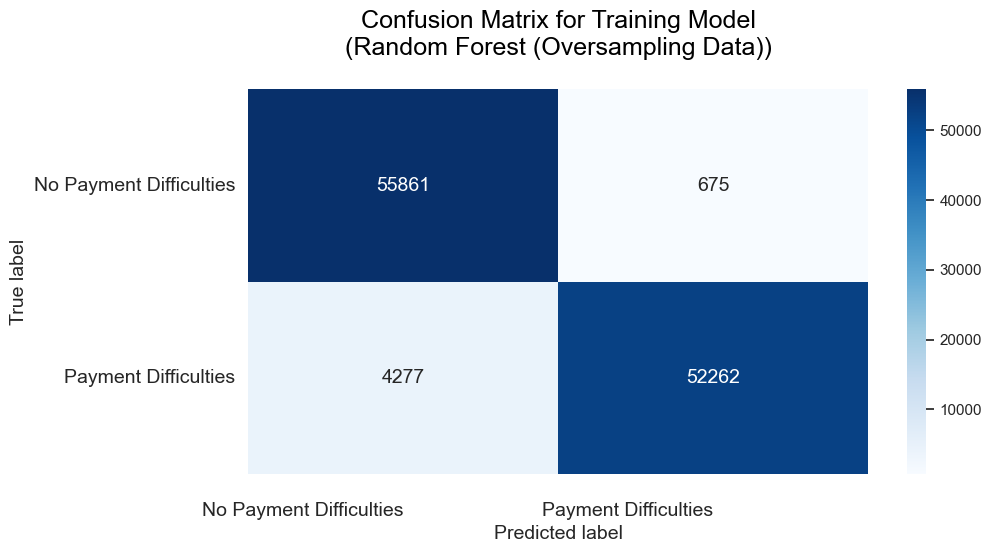

In [93]:
rforest = RandomForestClassifier()
rforest.fit(X_train,y_train)
predicto_1 = rforest.predict(X_test)

#print classification report
print(classification_report(y_test,predicto_1))
confusionmatrix(y_test,predicto_1,'Random Forest (Oversampling Data)')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226150
           1       1.00      1.00      1.00    226147

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



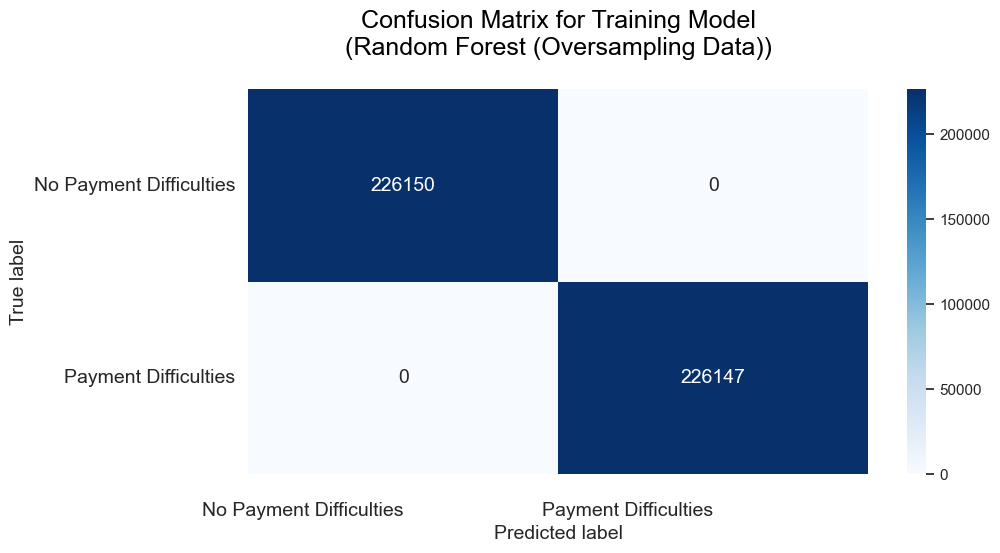

In [94]:
predicto_2 = rforest.predict(X_train)

#print classification report
print(classification_report(y_train,predicto_2))
confusionmatrix(y_train,predicto_2,'Random Forest (Oversampling Data)')

In [95]:
predlog_train=round(rforest.score(X_train,y_train)*100,2)
predlog_test=round(rforest.score(X_test,y_test)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy: {} %".format(predlog_train))

Test Accuracy: 95.62 %
Training Accuracy: 100.0 %


It can be seen that:

- Random Forest model with oversampling data gives 100.0 % correct results.

- There is 4.38 % error margin.

### Undersampling Data

              precision    recall  f1-score   support

           0       0.67      0.70      0.68      4953
           1       0.68      0.66      0.67      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



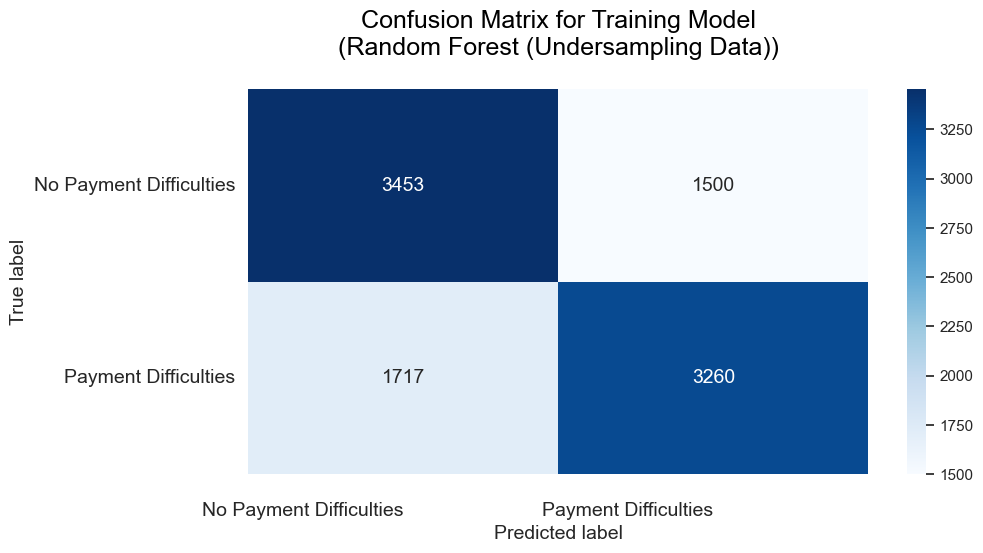

In [96]:
rforest_1 = RandomForestClassifier()
rforest_1.fit(X_train1,y_train1)
predictu_1 = rforest_1.predict(X_test1)

#print classification report
print(classification_report(y_test1,predictu_1))
confusionmatrix(y_test1,predictu_1,'Random Forest (Undersampling Data)')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19872
           1       1.00      1.00      1.00     19848

    accuracy                           1.00     39720
   macro avg       1.00      1.00      1.00     39720
weighted avg       1.00      1.00      1.00     39720



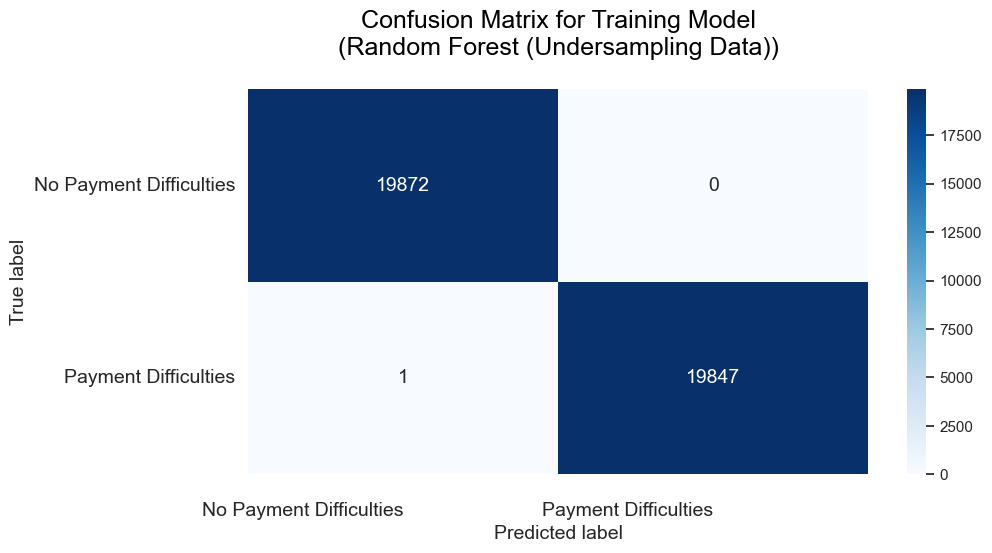

In [97]:
predictu_2 = rforest_1.predict(X_train1)

#print classification report
print(classification_report(y_train1,predictu_2))
confusionmatrix(y_train1,predictu_2,'Random Forest (Undersampling Data)')

In [159]:
predlog_train=round(rforest_1.score(X_train1,y_train1)*100,2)
predlog_test=round(rforest_1.score(X_test1,y_test1)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy: {} %".format(predlog_train))

Test Accuracy: 67.6 %
Training Accuracy: 100.0 %


It can be seen that:

- Random Forest model with oversampling data gives 100.0 % correct results.

- There is 32.4 % error margin.

## 3. XGBoost

### Oversampling Data

D:\Python\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56536
           1       0.99      0.91      0.95     56539

    accuracy                           0.95    113075
   macro avg       0.96      0.95      0.95    113075
weighted avg       0.96      0.95      0.95    113075



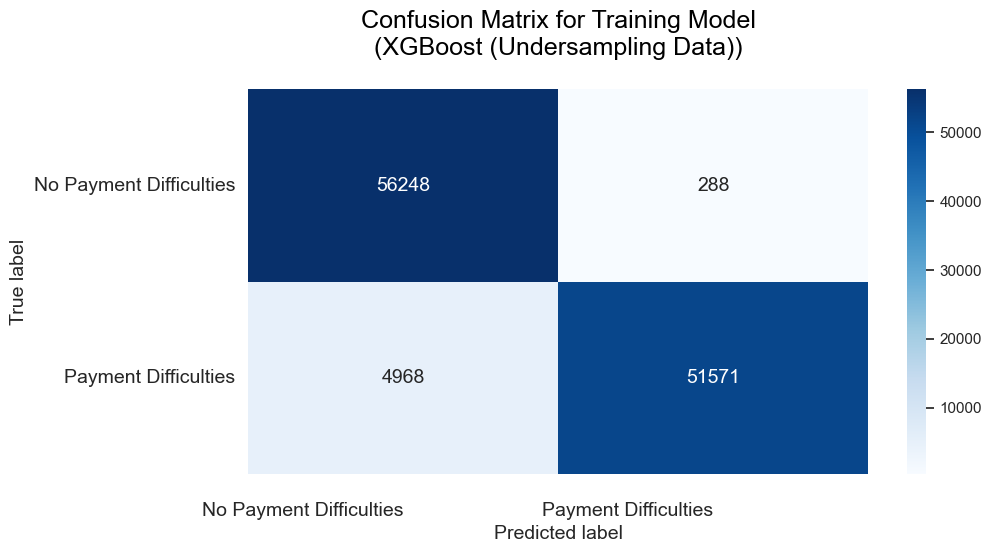

In [99]:
xgb_class = xgb.XGBClassifier(objectives = 'binary:logistic', random_state = 42)
xgb_class.fit(X_train,y_train.ravel())

predicto_x1 = xgb_class.predict(X_test)
print(classification_report(y_test,predicto_x1))
confusionmatrix(y_test,predicto_x1,'XGBoost (Undersampling Data)')

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226150
           1       1.00      0.91      0.95    226147

    accuracy                           0.96    452297
   macro avg       0.96      0.96      0.96    452297
weighted avg       0.96      0.96      0.96    452297



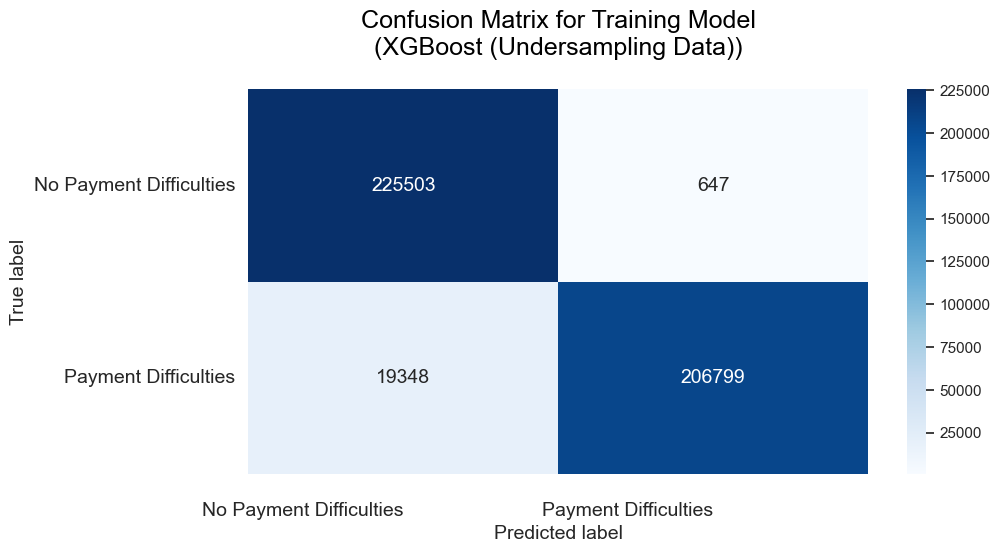

In [100]:
predicto_x2 = xgb_class.predict(X_train)
print(classification_report(y_train,predicto_x2))
confusionmatrix(y_train,predicto_x2,'XGBoost (Undersampling Data)')

In [101]:
predlog_train=round(xgb_class.score(X_train,y_train)*100,2)
predlog_test=round(xgb_class.score(X_test,y_test)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy: {} %".format(predlog_train))

Test Accuracy: 95.35 %
Training Accuracy: 95.58 %


It can be seen that:

- XGBClassifier model with oversampling data gives 95.58 % correct results.

- There is 0.23 % error margin.

### Undersampling Data

D:\Python\lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.68      0.69      0.68      4953
           1       0.68      0.67      0.68      4977

    accuracy                           0.68      9930
   macro avg       0.68      0.68      0.68      9930
weighted avg       0.68      0.68      0.68      9930



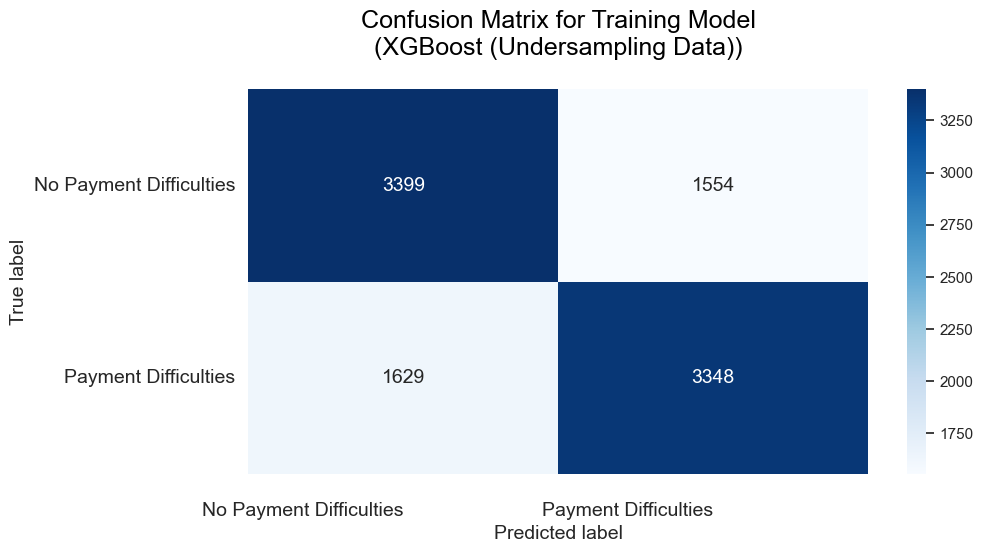

In [102]:
xgb_class = xgb.XGBClassifier(objectives = 'binary:logistic', random_state = 42)
xgb_class.fit(X_train1,y_train1.ravel())

predictu_x1 = xgb_class.predict(X_test1)
print(classification_report(y_test1,predictu_x1))
confusionmatrix(y_test1,predictu_x1,'XGBoost (Undersampling Data)')

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     19872
           1       0.81      0.81      0.81     19848

    accuracy                           0.81     39720
   macro avg       0.81      0.81      0.81     39720
weighted avg       0.81      0.81      0.81     39720



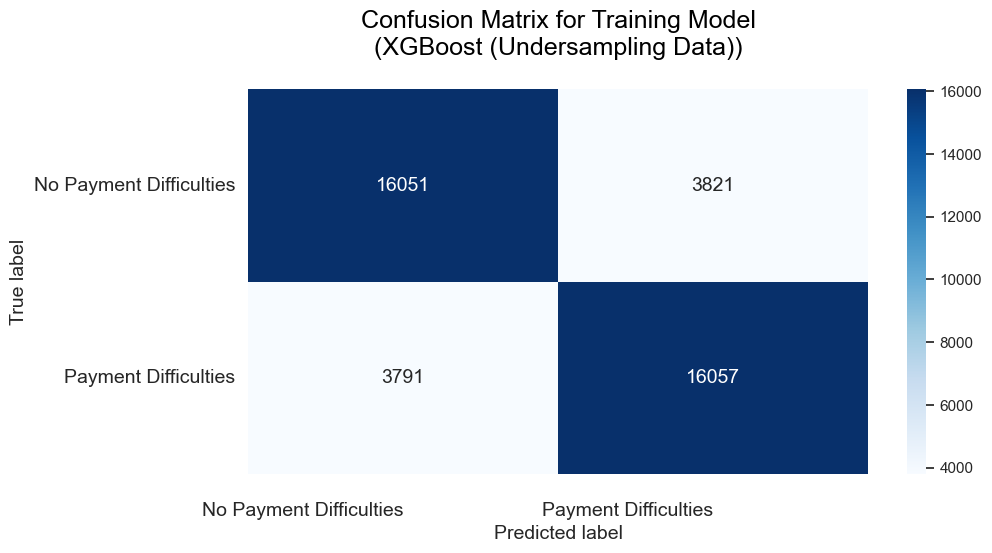

In [103]:
predictu_x2 = xgb_class.predict(X_train1)
print(classification_report(y_train1,predictu_x2))
confusionmatrix(y_train1,predictu_x2,'XGBoost (Undersampling Data)')

In [104]:
predlog_train=round(xgb_class.score(X_train1,y_train1)*100,2)
predlog_test=round(xgb_class.score(X_test1,y_test1)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy: {} %".format(predlog_train))

Test Accuracy: 67.95 %
Training Accuracy: 80.84 %


It can be seen that:

- XGBClassifier model with undersampling data gives 80.84 % correct results.

- There is 13.95 % error margin.

## 4. K-Nearest Neighbours

### Oversampling Data

              precision    recall  f1-score   support

           0       1.00      0.57      0.72     56536
           1       0.70      1.00      0.82     56539

    accuracy                           0.78    113075
   macro avg       0.85      0.78      0.77    113075
weighted avg       0.85      0.78      0.77    113075



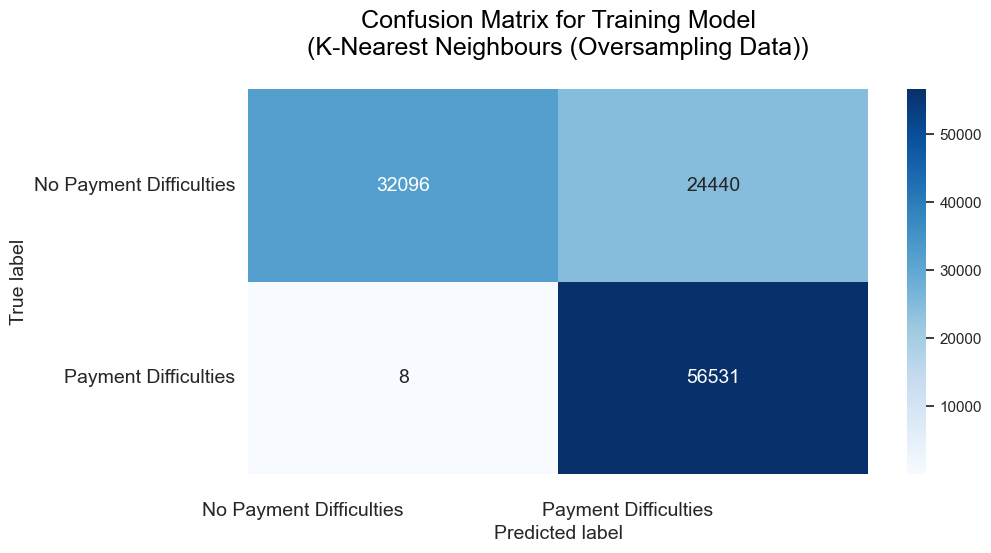

In [105]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train,y_train.ravel())

predicto_K1 = knn_model.predict(X_test)
print(classification_report(y_test,predicto_K1))
confusionmatrix(y_test,predicto_K1,'K-Nearest Neighbours (Oversampling Data)')

              precision    recall  f1-score   support

           0       1.00      0.68      0.81    226150
           1       0.76      1.00      0.86    226147

    accuracy                           0.84    452297
   macro avg       0.88      0.84      0.84    452297
weighted avg       0.88      0.84      0.84    452297



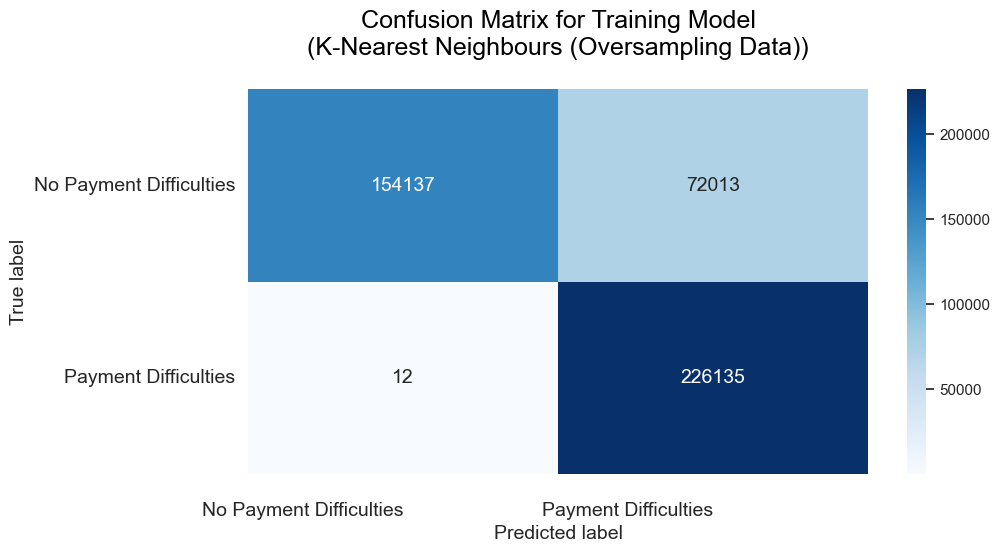

In [106]:
predicto_K2 = knn_model.predict(X_train)
print(classification_report(y_train,predicto_K2))
confusionmatrix(y_train,predicto_K2,'K-Nearest Neighbours (Oversampling Data)')

In [107]:
predlog_train=round(knn_model.score(X_train,y_train)*100,2)
predlog_test=round(knn_model.score(X_test,y_test)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy: {} %".format(predlog_train))

Test Accuracy: 78.38 %
Training Accuracy: 84.08 %


It can be seen that:

- K-Neighbour model with oversampling data gives 84.08 % correct results.

- There is 9.7 % error margin.

### Undersampling Data

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      4953
           1       0.61      0.62      0.61      4977

    accuracy                           0.61      9930
   macro avg       0.61      0.61      0.61      9930
weighted avg       0.61      0.61      0.61      9930



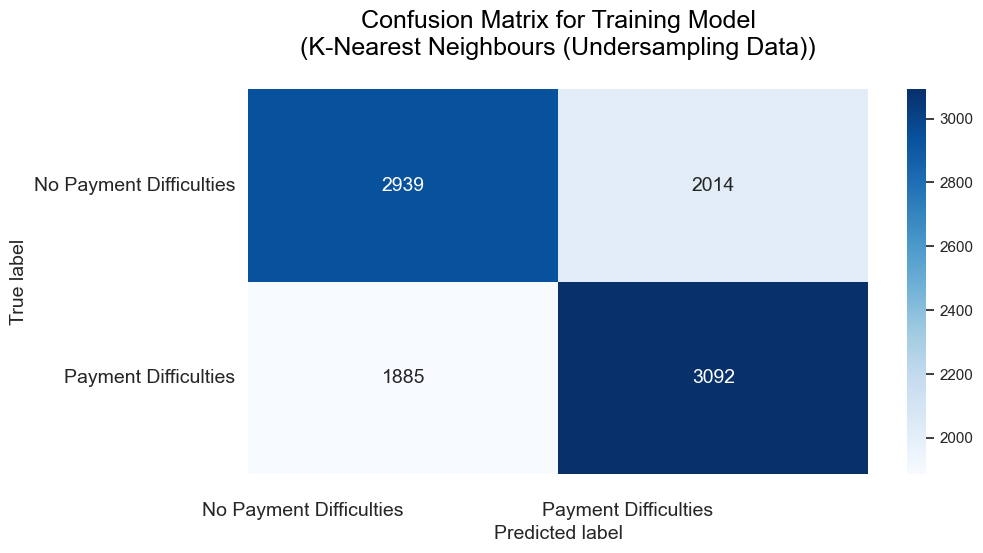

In [108]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train1,y_train1)

predict_K1 = knn_model.predict(X_test1)
print(classification_report(y_test1,predict_K1))
confusionmatrix(y_test1,predict_K1,'K-Nearest Neighbours (Undersampling Data)')

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     19872
           1       0.74      0.76      0.75     19848

    accuracy                           0.74     39720
   macro avg       0.74      0.74      0.74     39720
weighted avg       0.74      0.74      0.74     39720



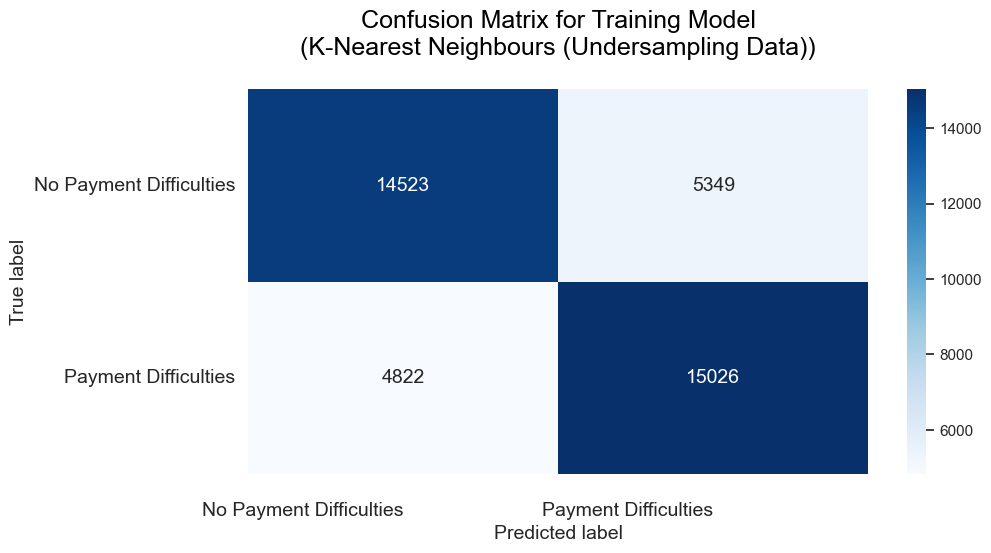

In [109]:
predict_K2 = knn_model.predict(X_train1)
print(classification_report(y_train1,predict_K2))
confusionmatrix(y_train1,predict_K2,'K-Nearest Neighbours (Undersampling Data)')

In [110]:
predlog_train=round(knn_model.score(X_train1,y_train1)*100,2)
predlog_test=round(knn_model.score(X_test1,y_test1)*100,2)
print("Test Accuracy: {} %".format(predlog_test))
print("Training Accuracy: {} %".format(predlog_train))

Test Accuracy: 60.74 %
Training Accuracy: 74.39 %


It can be seen that:

- K-Neighbour model with undersampling data gives 74.39 % correct results.

- There is 13.65 % error margin.

The prediction accuracy of the training data and test data on the <mark>Random Forest</mark> model with **oversampling data have a higher accuracy, precisio, and recall than the others**, so it can be said that the model is very good, that is, there is no underfitting or overfitting. 

**So the Random Forest model was chosen as the best model to predict the ability to pay customers**.

# Prediction

In [111]:
df_test = pd.read_csv('application_test.csv')
print('This Dataset has {} rows and {} columns'.format(df_test.shape[0], df_test.shape[1]))
df_test.head()

This Dataset has 48744 rows and 121 columns


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df_test['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 24533
Commercial associate    11402
Pensioner                9273
State servant            3532
Student                     2
Businessman                 1
Unemployed                  1
Name: count, dtype: int64

In [116]:
df_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

In [117]:
df_test['CODE_GENDER'] = df_test['CODE_GENDER'].replace(['XNA'], df_test['CODE_GENDER'].mode()[0])
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(['XNA'], df_test['ORGANIZATION_TYPE'].mode()[0])
df_test['Age'] = np.floor(df_test['DAYS_BIRTH'] / -365).astype(int)
df_test.drop(columns= 'DAYS_BIRTH', inplace=True)

## Data Preprocessing

### Detecting Duplication

In [118]:
df_test.duplicated().sum()

0

### Detecting Missing Values

In [119]:
ms_val = pd.DataFrame(df_test.isnull().sum(), columns = ['Total_Null_Values'])
ms_val['Percentage'] = (ms_val['Total_Null_Values'] / len(df_test)) * 100
ms_val = ms_val.sort_values(by='Percentage', ascending = False).reset_index()
ms_val = ms_val[ms_val['Percentage'] > 0 ]

print('There are {} columns with missing values'.format(ms_val.shape[0]))
ms_val

There are 64 columns with missing values


,index,Total_Null_Values,Percentage
0,COMMONAREA_MODE,33495,68.716150
1,COMMONAREA_AVG,33495,68.716150
2,COMMONAREA_MEDI,33495,68.716150
3,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...,...
59,OBS_60_CNT_SOCIAL_CIRCLE,29,0.059495
60,DEF_60_CNT_SOCIAL_CIRCLE,29,0.059495
61,OBS_30_CNT_SOCIAL_CIRCLE,29,0.059495
62,AMT_ANNUITY,24,0.049237


In [120]:
drop_col = ms_val[ms_val['Percentage'] > 40].sort_values(by='Percentage',ascending= False)
#any_null.reset_index().drop(columns = 'index')
drop_col = drop_col.reset_index().drop('level_0', axis = 1).rename(columns ={'index' : 'columns'})
drop_col

,columns,Total_Null_Values,Percentage
0,COMMONAREA_MODE,33495,68.716150
1,COMMONAREA_MEDI,33495,68.716150
2,COMMONAREA_AVG,33495,68.716150
3,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
5,NONLIVINGAPARTMENTS_AVG,33347,68.412523
6,FONDKAPREMONT_MODE,32797,67.284179
7,LIVINGAPARTMENTS_MODE,32780,67.249302
8,LIVINGAPARTMENTS_AVG,32780,67.249302
9,LIVINGAPARTMENTS_MEDI,32780,67.249302


In [121]:
#drop features that have large number of missing values (>40%)

col = list(drop_col['columns'])
df_test = df_test.drop(columns = col, axis = 1)
df_test = df_test.drop('SK_ID_CURR', axis = 1)

In [122]:
still_null = pd.DataFrame(df_test.isnull().sum(), columns = ['Total_Null_Values'])
still_null['Percentage'] = (still_null['Total_Null_Values'] / len(df_test)) * 100
still_null = still_null.sort_values(by='Percentage', ascending = False).reset_index()
still_null = still_null[still_null['Percentage'] > 0 ]

print('There still are {} columns with missing values'.format(still_null.shape[0]))
still_null

There still are 15 columns with missing values


,index,Total_Null_Values,Percentage
0,OCCUPATION_TYPE,15605,32.014197
1,EXT_SOURCE_3,8668,17.782701
2,AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.409732
3,AMT_REQ_CREDIT_BUREAU_QRT,6049,12.409732
4,AMT_REQ_CREDIT_BUREAU_MON,6049,12.409732
5,AMT_REQ_CREDIT_BUREAU_WEEK,6049,12.409732
6,AMT_REQ_CREDIT_BUREAU_DAY,6049,12.409732
7,AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.409732
8,NAME_TYPE_SUITE,911,1.868948
9,DEF_60_CNT_SOCIAL_CIRCLE,29,0.059495


In [123]:
df_test.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_

In [124]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df_test.select_dtypes(include=['object']).columns.tolist()
num_columns = df_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_test:
    if df_test[column].isnull().any():
        if(column in category_columns):
            df_test[column]=df_test[column].fillna(df_test[column].mode()[0])
        else:
            df_test[column]=df_test[column].fillna(df_test[column].median())

In [125]:
df_test.isnull().sum()

NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Age                           0
Length: 71, dtype: int64

## Numeric Data Type

### Feature Transformation

In [126]:
df_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52
1,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,49
2,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,54
3,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,38
4,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,35


In [127]:
uniq_col = pd.DataFrame(df_test[num_columns].nunique(),columns = ['Total_Unique']).reset_index()
uniq_col = uniq_col.rename(columns = {'index': 'columns'})

num_1 = []
num_2 = []
for i,y in enumerate(uniq_col['columns']):
    if uniq_col['Total_Unique'][i] > 2:
        num_1.append(y)
    else:
        num_2.append(y)

In [128]:
scaler = preprocessing.StandardScaler().fit(df_test[num_1])
df_test[num_1] = scaler.transform(df_test[num_1])

df_test[num_1].head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,-0.559988,-0.427809,0.142475,-0.553580,-0.037477,-0.164654,-0.483656,-0.056958,1.427241,-0.164830,...,-0.279167,-0.400896,-0.250398,-0.753470,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,-1.153865
1,-0.559988,-0.782413,-0.804537,-0.752831,-0.839362,1.009586,-0.498482,-1.168264,0.910437,-0.164830,...,-0.279167,-0.400896,-0.250398,1.226251,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
2,-0.559988,0.237075,0.401002,2.520066,0.497113,-0.147258,-0.498406,0.786092,-0.287579,-0.164830,...,-0.279167,-0.400896,-0.250398,0.252319,-0.042538,-0.036585,-0.048265,-0.078421,0.773588,1.170387
3,2.260729,1.345214,2.896221,1.223666,3.303709,0.358078,-0.480449,0.835352,-0.736836,2.081317,...,-0.279167,-0.400896,-0.250398,-0.827425,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.589324
4,0.850370,0.015447,0.297651,0.165019,0.483748,-0.775825,-0.482700,0.272381,-0.771247,0.958244,...,-0.279167,-0.400896,-0.250398,0.292141,-0.042538,-0.036585,-0.048265,-0.078421,-0.711321,0.008261


In [129]:
df_test[num_2] = df_test[num_2].loc[~df_test[num_2].index.duplicated(keep='first')]

df_test[num_2].head()

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Category Data Type
---

### Feature Transformation

In [130]:
df_test[category_columns]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Laborers,TUESDAY,Kindergarten
1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed
2,Cash loans,M,Y,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,FRIDAY,Business Entity Type 3
...,...,...,...,...,...,...,...,...,...,...,...,...
48739,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,Laborers,WEDNESDAY,Other
48740,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,MONDAY,Trade: type 7
48741,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
48742,Cash loans,M,N,N,Family,Commercial associate,Higher education,Married,House / apartment,Managers,MONDAY,Self-employed


In [131]:
uniq_cat = pd.DataFrame(df_test[category_columns].nunique(),columns = ['Total_Unique']).reset_index()
uniq_cat = uniq_cat.sort_values(by = 'Total_Unique', ascending = False).reset_index().drop(columns = 'level_0', axis=1)
uniq_cat = uniq_cat.rename(columns = {'index': 'columns'})

uniq_cat

,columns,Total_Unique
0,ORGANIZATION_TYPE,57
1,OCCUPATION_TYPE,18
2,NAME_TYPE_SUITE,7
3,NAME_INCOME_TYPE,7
4,WEEKDAY_APPR_PROCESS_START,7
5,NAME_HOUSING_TYPE,6
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,5
8,NAME_CONTRACT_TYPE,2
9,CODE_GENDER,2


In [132]:
df_test.drop(columns = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE'], inplace = True)

In [133]:
cat_cols = df_test.select_dtypes('object')
cols = list(cat_cols.columns)

cat = pd.DataFrame(cat_cols.nunique(),columns = ['Total_Unique']).reset_index()
cat = cat.rename(columns = {'index':'Columns'})

cat

,Columns,Total_Unique
0,NAME_CONTRACT_TYPE,2
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,NAME_TYPE_SUITE,7
5,NAME_INCOME_TYPE,7
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,5
8,NAME_HOUSING_TYPE,6
9,WEEKDAY_APPR_PROCESS_START,7


In [134]:
cat_1 = []
cat_2 = []
for i,y in enumerate(cat['Columns']):
    if cat['Total_Unique'][i] <= 2:
        cat_1.append(y)
    else:
        cat_2.append(y)

In [135]:
cat_1

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [136]:
cat_2

['NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START']

In [137]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
for i in cat_1:
    df_test[i]= label_encoder.fit_transform(df_test[i])
    
df_test[cat_1]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,0,0,1
1,0,1,0,1
2,0,1,1,1
3,0,0,0,1
4,0,1,1,0
...,...,...,...,...
48739,0,0,0,1
48740,0,0,0,0
48741,0,0,1,1
48742,0,1,0,0


In [138]:
for i in cat_2:
    onehots = pd.get_dummies(df_test[i], prefix = i)
    df_test = df_test.join(onehots)
    
df_test = df_test.drop(columns = cat_2)

In [139]:
df_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 100 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   NAME_CONTRACT_TYPE                                 48744 non-null  int32  
 1   CODE_GENDER                                        48744 non-null  int32  
 2   FLAG_OWN_CAR                                       48744 non-null  int32  
 3   FLAG_OWN_REALTY                                    48744 non-null  int32  
 4   CNT_CHILDREN                                       48744 non-null  float64
 5   AMT_INCOME_TOTAL                                   48744 non-null  float64
 6   AMT_CREDIT                                         48744 non-null  float64
 7   AMT_ANNUITY                                        48744 non-null  float64
 8   AMT_GOODS_PRICE                                    48744 non-null  float64
 9   REGIO

In [142]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 103 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    TARGET                                             int64  
 1    NAME_CONTRACT_TYPE                                 int64  
 2    CODE_GENDER                                        int64  
 3    FLAG_OWN_CAR                                       int64  
 4    FLAG_OWN_REALTY                                    int64  
 5    CNT_CHILDREN                                       float64
 6    AMT_INCOME_TOTAL                                   float64
 7    AMT_CREDIT                                         float64
 8    AMT_ANNUITY                                        float64
 9    AMT_GOODS_PRICE                                    float64
 10   REGION_POPULATION_RELATIVE                         float64
 11   DAYS_EMPLOYED                        

In [140]:
train = set(df_train.columns)
train.remove('TARGET')

In [141]:
filter_col = train - set(df_test.columns)
filter_col = list(filter_col)
filter_col

['NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown']

In [145]:
df_test[filter_col] = 0
df_test[filter_col]

,NAME_INCOME_TYPE_Maternity leave,NAME_FAMILY_STATUS_Unknown
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
48739,0,0
48740,0,0
48741,0,0
48742,0,0


In [146]:
cols_train = list(df_train.columns)
cols_train.remove('TARGET')
df_test = df_test[cols_train]

In [147]:
predictions = rforest.predict(df_test)
df_test['TARGET'] = predictions

C:\Users\Smith\AppData\Local\Temp\ipykernel_30872\2942140959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['TARGET'] = predictions


In [ ]:
df_test['TARGET'].value_counts()

In [148]:
df_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,TARGET
0,0,0,0,1,-0.559988,-0.427809,0.142475,-0.553580,-0.037477,-0.164654,...,False,False,False,False,False,False,False,True,False,0
1,0,1,0,1,-0.559988,-0.782413,-0.804537,-0.752831,-0.839362,1.009586,...,False,False,True,False,False,False,False,False,False,1
2,0,1,1,1,-0.559988,0.237075,0.401002,2.520066,0.497113,-0.147258,...,False,False,False,True,False,False,False,False,False,0
3,0,0,0,1,2.260729,1.345214,2.896221,1.223666,3.303709,0.358078,...,False,False,False,False,False,False,False,False,True,0
4,0,1,1,0,0.850370,0.015447,0.297651,0.165019,0.483748,-0.775825,...,False,False,True,False,False,False,False,False,False,1


In [149]:
columns_to_move = ['TARGET']

# Create a list of all columns with the desired order
new_order = columns_to_move + [col for col in df_test.columns if col not in columns_to_move]

# Reorder the DataFrame columns
df_test = df_test[new_order]

df_test.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0,0,0,0,1,-0.559988,-0.427809,0.142475,-0.553580,-0.037477,...,False,False,False,False,False,False,False,False,True,False
1,1,0,1,0,1,-0.559988,-0.782413,-0.804537,-0.752831,-0.839362,...,False,False,False,True,False,False,False,False,False,False
2,0,0,1,1,1,-0.559988,0.237075,0.401002,2.520066,0.497113,...,False,False,False,False,True,False,False,False,False,False
3,0,0,0,0,1,2.260729,1.345214,2.896221,1.223666,3.303709,...,False,False,False,False,False,False,False,False,False,True
4,1,0,1,1,0,0.850370,0.015447,0.297651,0.165019,0.483748,...,False,False,False,True,False,False,False,False,False,False


In [150]:
X = df_test.drop(columns = 'TARGET')
y = df_test['TARGET']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6337
           1       0.86      0.71      0.78      3412

    accuracy                           0.86      9749
   macro avg       0.86      0.82      0.84      9749
weighted avg       0.86      0.86      0.85      9749



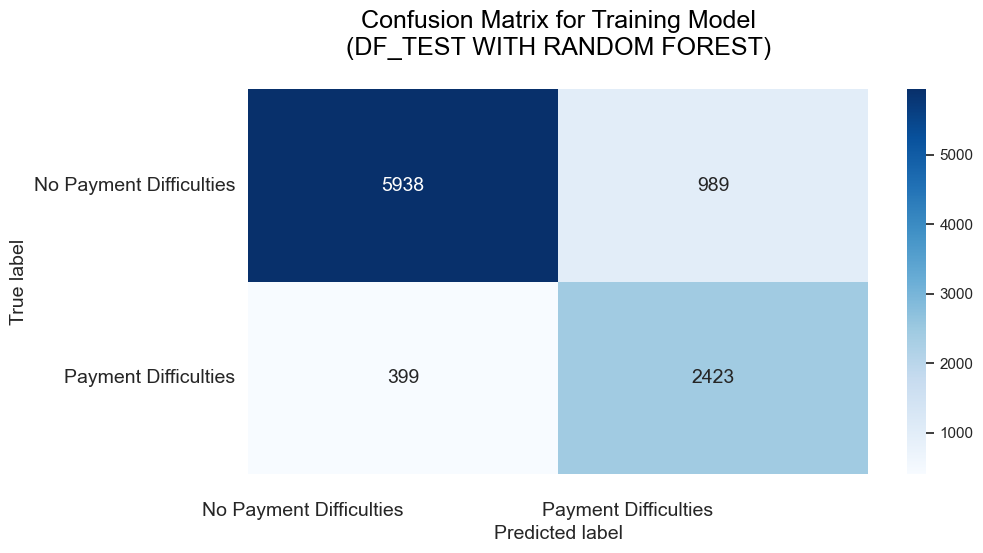

In [155]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
predictions = rf_model.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test, 'DF_TEST WITH RANDOM FOREST')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25318
           1       1.00      1.00      1.00     13677

    accuracy                           1.00     38995
   macro avg       1.00      1.00      1.00     38995
weighted avg       1.00      1.00      1.00     38995



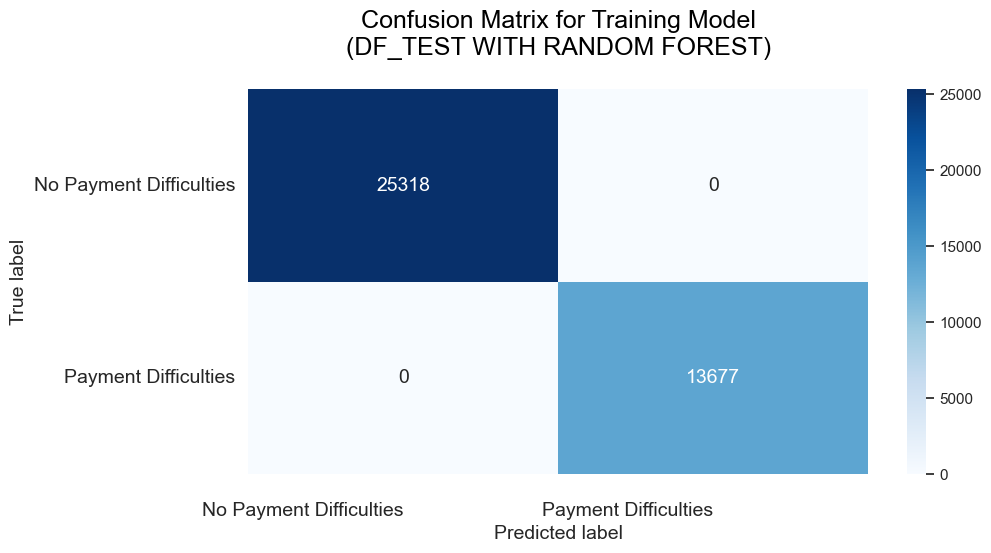

In [157]:
predictions = rf_model.predict(X_train)
  
# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train, 'DF_TEST WITH RANDOM FOREST')

# Recommendation

1. All customers should be directed to repay loans on a revolving basis.<br><br>

2. Conduct further monitoring of customers, especially the nominal price of the proposed loan, and the nominal income, because it has been found that customers who are not working and are on maternity leave, have the most problems in repaying loans.<br><br>

3. Create a campaign so that more students, accountants, the high skill tech staff, and managers are interested in applying for a loan